In [ ]:
!pip install h3
!pip install pyshp
!pip install geojson
%tensorflow_version 1.x

  Created wheel for h3: filename=h3-3.4.3-cp36-cp36m-linux_x86_64.whl size=81854 sha256=f9c9c540e36ab2f8d87bbbb286bf39e07b649d1f0bc7ac612a3e4ca895bbe695
  Stored in directory: /root/.cache/pip/wheels/7f/8e/74/c5ae2b6a5e3f28239b9bea822e38a08075a5eb05589a0d2a7c
Successfully built h3
     |████████████████████████████████| 225kB 2.8MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=2af78d86ac8e41b22f2030637c1d0579e6810fb8f075462f360bf3625dfe2e57
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
TensorFlow 1.x selected.


In [ ]:
import os
import zipfile
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import shapefile
import geojson

from tqdm.notebook import tqdm
from h3 import h3

from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
from geojson.feature import *

import folium
import json
import tensorflow as tf
print(tf.__version__)

1.15.2


# Data

In [ ]:
# data_dir = os.getcwd() + '/data'
data_dir = os.getcwd()
data_dir

'/content'

## Exploration

### Location data

In [ ]:
# Download location data
urllib.request.urlretrieve('https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip', f'{data_dir}/taxi_zones.zip')
with zipfile.ZipFile(f'{data_dir}/taxi_zones.zip','r') as zip_ref:
    zip_ref.extractall(f'{data_dir}/shape')

In [ ]:
sf = shapefile.Reader(f'{data_dir}/shape/taxi_zones.shp')
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = {field: i for i, field in enumerate(fields_name)}
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


### Location ID to coordinates

In [ ]:
df_loc.loc[df_loc.loc[:,'LocationID']==1, 'longitude']

0    936681.749805
Name: longitude, dtype: float64

In [ ]:
df_trips = taxi_df
df_trips.head()

,tpep_pickup_datetime,PULocationID,DOLocationID
0,2019-09-01 00:06:48,186,161
1,2019-09-01 00:29:17,161,256
2,2019-09-01 00:41:32,145,145
3,2019-09-01 00:59:11,145,145
4,2019-09-01 00:39:41,95,93


In [ ]:
def id_lon(id):
    return df_loc.loc[df_loc.loc[:,'LocationID']==id, 'longitude']

def id_lat(id):
    return df_loc.loc[df_loc.loc[:,'LocationID']==id, 'latitude']

# df_trips['start_lon'] = (df_loc)
# df_trips['start_lat']
df_trips['start_lon'] = df_trips['PULocationID'].apply(id_lon)

KeyboardInterrupt: ignored

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/usr/lib/python3.6/abc.py", line 180, in __instancecheck__
    def __instancecheck__(cls, instance):
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
df_trips.head()

## Trip data

### Download

In [ ]:
# Download NYC trips data
# years = [2016, 2019]
years = [2016]
# months = range(1, 13)
months = [6]
for year in years:
    for month in months:
        urllib.request.urlretrieve(
            'https://s3.amazonaws.com/nyc-tlc/trip+data/'+ \
            f'yellow_tripdata_{year}-{month:0=2d}.csv',
            f'{data_dir}/nyc.{year}-{month:0=2d}.csv')

In [ ]:
# Preview data
df_tmp = pd.read_csv(f'{data_dir}/nyc.2016-06.csv', nrows=5)
df_tmp.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0,0.3,17.76


### Visualization

In [ ]:
# Load csv to dataframe

# dtypes = {
#     'tpep_pickup_datetime': 'str',
#     'PULocationID': 'int',
#     'DOLocationID': 'int'}

cols = (
    'tpep_pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
)

# j, chunksize = 1, 100_000
year = 2016
chunks = []
chunksize = 500_000
# for month in range(1,7):
for month in [6]:
    fp = f'nyc.{year}-{month:0=2d}.csv'
    for chunk in tqdm(pd.read_csv(fp, chunksize=chunksize, usecols=cols)):
        # df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        # df['pickup_hour'] = [int(x[11:13]) for x in df['tpep_pickup_datetime']]
        # df['dropoff_hour'] = [int(x[11:13]) for x in df['tpep_dropoff_datetime']]
        # df.index += j
        # df.to_sql('table_record', nyc_database, if_exists='append')
        # j = df.index[-1] + 1
        chunks.append(chunk)

# Merge chunks
df_trips = pd.concat(chunks)

# Free chunk list from memory
del chunks

df_trips.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 3 columns):
 #   Column                Dtype  
---  ------                -----  
 0   tpep_pickup_datetime  object 
 1   pickup_longitude      float64
 2   pickup_latitude       float64
dtypes: float64(2), object(1)
memory usage: 254.9+ MB


In [ ]:
df_trips.head()

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2016-06-09 21:06:36,-73.983360,40.760937
1,2016-06-09 21:06:36,-73.981720,40.736668
2,2016-06-09 21:06:36,-73.994316,40.751072
3,2016-06-09 21:06:36,-73.982361,40.773891
4,2016-06-09 21:06:36,-73.987106,40.733173


In [ ]:
# Simplify column names
df_trips.columns = ('date', 'lng', 'lat')
test = df_trips.sample(frac=0.15, replace=False, random_state=1)

In [ ]:
test.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount
8863569,2016-06-26 12:22:23,2016-06-26 12:29:16,-73.962524,40.770065,-73.975349,40.758430,9.36
2554264,2016-06-11 08:57:16,2016-06-11 09:05:13,-73.980644,40.737801,-74.000076,40.732952,9.95
7749996,2016-06-23 15:15:11,2016-06-23 15:20:23,-73.976173,40.756962,-73.972885,40.765091,5.80
659829,2016-06-02 12:44:31,2016-06-02 13:03:41,-73.952858,40.786709,-73.967087,40.766479,13.30
9430754,2016-06-28 05:47:19,2016-06-28 06:10:39,-73.990395,40.756359,-73.864349,40.770020,43.34


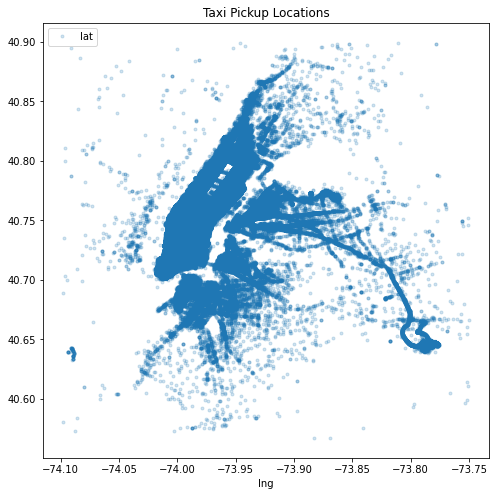

In [ ]:
test = test[test.lat>40.55]
test = test[test.lat<40.9]
test = test[test.lng>-74.1]
test = test[test.lng<-73.75]
# test = test[test.pickup_latitude>40.55]
# test = test[test.pickup_latitude<40.9]
# test = test[test.pickup_longitude>-74.1]
# test = test[test.pickup_longitude<-73.75]
test.plot(x='lng', y='lat',style='.',alpha=0.2,figsize=(8,8));
# test.plot(x='pickup_longitude', y='pickup_latitude',style='.',alpha=0.2,figsize=(8,8))
plt.title('Taxi Pickup Locations')
plt.savefig('trips_point.png')

In [ ]:
# Counts how many points are within the hex
res = 8
df_aggreg, df_tmp = counts_by_hexagon(df=test, resolution=res)
df_aggreg.sort_values(by="value", ascending=False, inplace=True)

In [ ]:
# Creates a map using Folium
hexmap = choropleth_map(df_aggreg=df_aggreg, with_legend=True, fill_opacity=0.4)
# vis_dir = os.getcwd() + '/visualization'
# hexmap.save(f'nyc-2016-06.res-{res}.html')
display(hexmap)

## Preprocessing

### Build `mapped_int_matrix`

In [ ]:
# Visualize hexagonal grid of Manhattan

sf = [
    [37.813318999983238, -122.4089866999972145],
    [37.7866302000007224, -122.3805436999997056],
    [37.7198061999978478, -122.3544736999993603],
    [37.7076131999975672, -122.5123436999983966],
    [37.7835871999971715, -122.5247187000021967],
    [37.8151571999998453, -122.4798767000009008],
    [37.813318999983238, -122.4089866999972145],
]

manhattan = {
    'coords': [
        [40.70484714530104, -74.0200424194336],
        [40.699641625343126, -74.01283264160156],
        [40.71031250340588, -73.97712707519531],
        [40.72930763943153, -73.97026062011719],
        [40.80029619806279, -73.92631530761719],
        [40.81874599835864, -73.96820068359375],
        [40.751678516237334, -74.01180267333984],
        [40.70484714530104, -74.0200424194336] # first point repeated
    ],
    'MN': (13, 12), # Num rows and columns
    'bottom_left': (40.702764986136835, -74.01626586914062), # Bottom left coords of grid
    'res': 8 # H3 resolution, higher is smaller hexagons
}

lga=[
    [40.703545803451426, -74.0203857421875],
    [40.699901911003046, -74.01283264160156],
    [40.71031250340588, -73.97781372070312],
    [40.772481879178564, -73.85181427001953],
    [40.81796653313175, -73.96682739257812],
    [40.75115834874022, -74.01248931884766],
    [40.703545803451426, -74.0203857421875]
]

geoJson = {
    'type': 'Polygon',
    'coordinates': [manhattan['coords']]
}

polyline = geoJson['coordinates'][0]
polyline.append(polyline[0])
lat = [p[0] for p in polyline]
lng = [p[1] for p in polyline]
m = folium.Map(location=[np.mean(lat), np.mean(lng)], zoom_start=13, tiles='cartodbpositron')
my_PolyLine=folium.PolyLine(locations=polyline, weight=1,color="green")
m.add_child(my_PolyLine)

hexagons = list(h3.polyfill(geoJson, res=8)) # H3 addresses
polygons = h3.h3_set_to_multi_polygon([hexagons[0]])
polylines = []
lat = []
lng = []
for hex in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # print('polygons:', polygons)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    # print('outlines:', outlines)
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0], polyline))
    lng.extend(map(lambda v:v[1], polyline))
    polylines.append(polyline)

for polyline in polylines:
    my_PolyLine=folium.PolyLine(locations=polyline, weight=1, color='red')
    m.add_child(my_PolyLine)
display(m)

In [ ]:
# Determine angle of each neighbor's direction given a hexagon

hex_map = folium.Map(
    location=[40.718728, -73.943802],
    zoom_start=13,
    tiles="cartodbpositron",
    attr='© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>'
)

# lat, lng = 40.9, -74.1
# lat, lng = 40.718728, -73.943802
lat, lng = manhattan['bottom_left']

# lats = 40.55, 40.9
# lngs = -74.1, -73.75

def draw_hex(lat, lng, hex_map, res=8, ring_size=1):
    hex_id = h3.geo_to_h3(lat, lng, res)
    ring = h3.k_ring(hex_id, ring_size=ring_size)
    coords = h3.h3_to_geo_boundary(h3_address=hex_id, geo_json=True)
    geometry = {'type': 'Polygon', 'coordinates': [coords]}
    feature = geojson.feature.Feature(geometry=geometry, id=hex_id, properties={'value': 1})
    features = geojson.feature.FeatureCollection(
        [feature] +
        [ft(hex_id) for hex_id in ring]
    )
    folium.GeoJson(
        json.dumps(features),
        style_function=lambda feature: {
            # 'fillColor': custom_cm(feature['properties']['value']),
            # 'color': border_color,
            'weight': 1,
            # 'fillOpacity': fill_opacity
        },
    ).add_to(hex_map)

    folium.Marker(
        location=h3.h3_to_geo(hex_id),
        # popup='Mt. Hood Meadows',
        # icon=folium.Icon(icon='cloud')
    ).add_to(hex_map)
    return feature

def ft(h3_address, geo_json=True):
    return geojson.feature.Feature(geometry={'type': 'Polygon', 'coordinates': [h3.h3_to_geo_boundary(h3_address, geo_json)]})

# draw_hex(lat, lng, hex_map)
hex_id = h3.geo_to_h3(lat, lng, 8)
ring = [*h3.k_ring(hex_id, 1)]
ring.remove(hex_id)
f1 = ft(hex_id)
f2 = ft(ring[2])
folium.GeoJson(f1, style_function=lambda x: {'color': 'red', 'weight': 1} ).add_to(hex_map)
folium.GeoJson(f2, style_function=lambda x: {'color': 'blue', 'weight': 1}).add_to(hex_map)

def angle(hex1, hex2):
    '''
    Angle of vector going from hex1 to hex2
    '''
    hex1 = np.array(h3.h3_to_geo(hex1)[::-1])
    hex2 = np.array(h3.h3_to_geo(hex2)[::-1])
    diff = hex2 - hex1
    return np.arctan2(diff[1], diff[0])

def dangle(a, b):
    '''
    Delta angle i.e. minimum difference between two angles
    Code link: https://stackoverflow.com/a/1878936
    '''
    return min(2*np.pi - abs(a-b), abs(a-b))

# Angle of each direction found by hand
print('0:', angle(hex_id, ring[5]))
print('1:', angle(hex_id, ring[2]))
print('2:', angle(hex_id, ring[1]))
print('3:', angle(hex_id, ring[4]))
print('4:', angle(hex_id, ring[3]))
print('5:', angle(hex_id, ring[0]))

dirs = [
    1.8731245676315982,
    0.5843518486679132,
    -0.21440190623585376,
    -1.2685370439515593,
    -2.557114616340124,
    2.927294246874747
]

print({i: dangle(angle(hex_id, ring[2]), dir) for i, dir in enumerate(dirs)})
display(hex_map)

0: 2.927294246874747
1: -1.2685370439515593
2: 0.5843518486679132
3: 1.8731245676315982
4: -0.21440190623585376
5: -2.557114616340124
{0: 3.1415236955964287, 1: 1.8528888926194726, 2: 1.0541351377157056, 3: 0.0, 4: 1.2885775723885649, 5: 2.08735401635328}


In [ ]:
# Build matrix of h3 addresses corresponding to hexagonal grid

manhattan = {
    'coords': [
        [40.70484714530104, -74.0200424194336],
        [40.699641625343126, -74.01283264160156],
        [40.71031250340588, -73.97712707519531],
        [40.72930763943153, -73.97026062011719],
        [40.80029619806279, -73.92631530761719],
        [40.81874599835864, -73.96820068359375],
        [40.751678516237334, -74.01180267333984],
        [40.70484714530104, -74.0200424194336] # first point repeated
    ],
    'MN': (13, 12), # Num rows and columns
    'bottom_left': (40.702764986136835, -74.01626586914062), # Bottom left coords of grid
    'res': 8 # H3 resolution, higher is smaller hexagons
}

# M num rows, N num columns, counted by hand
M, N = manhattan['MN']

def angle(hex1, hex2):
    '''
    Angle of vector going from hex1 to hex2
    '''
    hex1 = np.array(h3.h3_to_geo(hex1)[::-1])
    hex2 = np.array(h3.h3_to_geo(hex2)[::-1])
    diff = hex2 - hex1
    return np.arctan2(diff[1], diff[0])

def dangle(a, b):
    '''
    Delta angle i.e. minimum difference between two angles
    Code link: https://stackoverflow.com/a/1878936
    '''
    return min(2*np.pi - abs(a-b), abs(a-b))

def get_neighbor_index(i, j):
    '''
        0
    5       1
      center
    4       2
        3
    Return index of neighbor 0, 1, 2, 3, 4, 5 in the matrix
    '''
    neighbor_matrix_ids = []
    if j % 2 == 0:
        neighbor_matrix_ids = [[i - 1, j    ],
                               [i,     j + 1],
                               [i + 1, j + 1],
                               [i + 1, j    ],
                               [i + 1, j - 1],
                               [i    , j - 1]]
    elif j % 2 == 1:
        neighbor_matrix_ids = [[i - 1, j    ],
                               [i - 1, j + 1],
                               [i    , j + 1],
                               [i + 1, j    ],
                               [i    , j - 1],
                               [i - 1, j - 1]]
    return neighbor_matrix_ids

def build_mat(valid_hexs, bottom_left, M, N, res=8):
    '''
    Build matrix of H3 addresses
    '''
    mat = [[None]*N for _ in range(M)]
    i, j = len(mat)-1, 0 # Bottom left element
    mat[-1][0] = h3.geo_to_h3(*bottom_left, res)

    # BFS
    q = [(i,j)] # Queue
    while q:
        i, j = q.pop(0)
        cur_hex = mat[i][j]

        # Add to mat
        ring = [*h3.k_ring(cur_hex, ring_size=1)]
        ring.remove(cur_hex)
        ring = [hex for hex in ring if hex in valid_hexs and hex not in q]
        neighbors_idx = get_neighbor_index(i,j)
        for neighbor in ring:
            direction = neighbor_direction(cur_hex, neighbor) # int from 0-5
            neighbor_idx = neighbors_idx[direction]
            if not is_valid_idx(neighbor_idx, mat, M, N): continue

            mat[neighbor_idx[0]][neighbor_idx[1]] = neighbor
            q.append(neighbor_idx)
    return mat

def neighbor_direction(cur, neighbor):
    '''
    Determine direction of neighbor through angles
        0
    5       1
      center
    4       2
        3
    '''
    angles = [
        1.8731245676315982,
        0.5843518486679132,
        -0.21440190623585376,
        -1.2685370439515593,
        -2.557114616340124,
        2.927294246874747
    ]
    dangles = [dangle(angle(cur, neighbor), a) for a in angles]
    return np.argmin(dangles)

def is_valid_idx(idx, mat, M, N):
    return 0 <= idx[0] < M and 0 <= idx[1] < N and mat[idx[0]][idx[1]] is None

# mat = build_mat(hexagons, manhattan['bottom_left'] , M, N)
# for r in mat: print(r)

# Create mappped_int_matrix

def get_mapped_int_matrix(city):
    '''
    Return mapped_int_matrix of city
    and `h3_map` - dict of {h3_id: mapped_int_matrix cell id}
    '''
    city_polygon_geojson = {
        'type': 'Polygon',
        'coordinates': [city['coords']]
    }
    bottom_left = city['bottom_left']
    M, N        = city['MN']
    res         = city['res']
    valid_hexs  = [* h3.polyfill(city_polygon_geojson, res=res)]

    mat = build_mat(valid_hexs, bottom_left, M, N)
    h3_map = h3_to_int(mat)
    mapped_int_matrix = np.array([[_h3_to_cell(mat[i][j], h3_map) for j in range(len(mat[0]))] for i in range(len(mat))])
    return mapped_int_matrix, h3_map

def _h3_to_cell(h3_id, h3_map):
    return h3_map[h3_id] if h3_id in h3_map else -1

def h3_to_int(mat):
    h3_map = {}
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j] is None: continue
            h3_map[mat[i][j]] = i*N + j
    return h3_map

mapped_int_matrix, h3_map = get_mapped_int_matrix(manhattan)
print('mapped_int_matrix:\n',mapped_int_matrix)
print('h3_map:\n', h3_map)

mapped_int_matrix:
 [[ -1  -1  -1  -1  -1  -1  -1  -1   8  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1  20  21  22  -1]
 [ -1  -1  -1  -1  -1  -1  30  31  32  33  34  35]
 [ -1  -1  -1  -1  -1  -1  42  43  44  45  46  47]
 [ -1  -1  -1  -1  52  53  54  55  56  57  58  -1]
 [ -1  -1  -1  -1  64  65  66  67  68  69  -1  -1]
 [ -1  -1  -1  75  76  77  78  79  80  81  -1  -1]
 [ -1  -1  86  87  88  89  90  91  -1  -1  -1  -1]
 [ -1  -1  98  99 100 101 102 103  -1  -1  -1  -1]
 [ -1 109 110 111 112 113 114  -1  -1  -1  -1  -1]
 [ -1 121 122 123 124 125  -1  -1  -1  -1  -1  -1]
 [132 133 134 135 136  -1  -1  -1  -1  -1  -1  -1]
 [144 145 146 147 148  -1  -1  -1  -1  -1  -1  -1]]
h3_map:
 {'882a1008c7fffff': 8, '882a100889fffff': 20, '882a1008c3fffff': 21, '882a1008ddfffff': 22, '882a100887fffff': 30, '882a100881fffff': 31, '882a10088bfffff': 32, '882a1008d5fffff': 33, '882a1008d1fffff': 34, '882a1008d9fffff': 35, '882a1008b9fffff': 42, '882a100883fffff': 43, '882a10089dfffff': 44, '882a100

In [ ]:
# Create mappped_int_matrix

def get_mapped_int_matrix(city):
    '''
    Return mapped_int_matrix of city
    and `h3_map` - dict of {h3_id: mapped_int_matrix cell id}
    '''
    city_polygon_geojson = {
        'type': 'Polygon',
        'coordinates': [city['coords']]
    }
    bottom_left = city['bottom_left']
    M, N        = city['MN']
    res         = city['res']
    valid_hexs  = [* h3.polyfill(city_polygon_geojson, res=res)]

    mat = build_mat(valid_hexs, bottom_left, M, N)
    h3_map = h3_to_int(mat)
    mapped_int_matrix = np.array([[_h3_to_cell(mat[i][j], h3_map) for j in range(len(mat[0]))] for i in range(len(mat))])
    return mapped_int_matrix, h3_map

def _h3_to_cell(h3_id, h3_map):
    return h3_map[h3_id] if h3_id in h3_map else -1

mapped_int_matrix, h3_map = get_mapped_int_matrix(manhattan)

### Process trip data

In [ ]:
def total_min(row, prefix):
    return row[f'{prefix}_hour']*60 + row[f'{prefix}_hour']

def t_from_total_min(row, prefix, T=144):
    interval = 60*24/T
    return int(row[f'{prefix}_total_min'] / interval)

In [ ]:
df_trips = pd.read_pickle('nyc.2016-06.pkl')
df_trips.head()

NameError: ignored

In [ ]:
# Process csv

import time

cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'total_amount',
]

def get_t(tpep_datetime):
    return ((tpep_datetime.str.slice(11,13).astype(int)*60 + tpep_datetime.str.slice(14,16).astype(int))/10).astype(int)

def geo_to_h3(lat, lng, res=8):
    f = lambda x, y: h3.geo_to_h3(x, y, res=res)
    return pd.Series(map(f, lat, lng))

def h3_to_cell(h3_id, h3_map):
    f = lambda x: h3_map[x] if x in h3_map else -1
    return pd.Series(map(f, h3_id))


# j, chunksize = 1, 100_000
year = 2016
chunks = []
chunksize = 500_000
# for month in range(1,7):
for month in [6]:
    fp = f'nyc.{year}-{month:0=2d}.csv'
    for chunk in tqdm(pd.read_csv(fp, chunksize=chunksize, usecols=cols)):
        # df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        # df['pickup_hour'] = [int(x[11:13]) for x in df['tpep_pickup_datetime']]
        # df['dropoff_hour'] = [int(x[11:13]) for x in df['tpep_dropoff_datetime']]
        # df.index += j
        # df.to_sql('table_record', nyc_database, if_exists='append')
        # j = df.index[-1] + 1
        chunks.append(chunk)

# Merge chunks
df_trips = pd.concat(chunks)

# Free chunk list from memory
del chunks

print(df_trips.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   pickup_longitude       float64
 3   pickup_latitude        float64
 4   dropoff_longitude      float64
 5   dropoff_latitude       float64
 6   total_amount           float64
dtypes: float64(5), object(2)
memory usage: 594.7+ MB
None


In [ ]:
# Process data
start = time.time()

def process(df, h3_map, T=144):
    processed = pd.DataFrame()
    processed['start_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    processed['start_t'] = get_t(df_trips.loc[:,'tpep_pickup_datetime'])
    processed['end_t'] = get_t(df_trips.loc[:,'tpep_dropoff_datetime'])
    processed['duration'] = processed.loc[:,'end_t'] - processed.loc[:,'start_t']
    # Adjust for negative duration i.e. dropoff after midnight
    processed.loc[processed['end_t'] < processed['start_t'], 'duration'] = T - processed['start_t'] + processed['end_t']

    processed['start_h3'] = geo_to_h3(df_trips['pickup_latitude'].values, df_trips['pickup_longitude'].values)
    processed['end_h3'] = geo_to_h3(df_trips['dropoff_latitude'].values, df_trips['dropoff_longitude'].values)
    processed['start_cell'] = h3_to_cell(processed['start_h3'].values, h3_map)
    processed['end_cell'] = h3_to_cell(processed['end_h3'].values, h3_map)
    processed['reward'] = df_trips.loc[:,'total_amount']

    # Drop out-of-bounds trips
    processed.drop(processed[processed.start_cell < 0].index, inplace=True)
    processed.drop(processed[processed.end_cell < 0].index, inplace=True)

    # Drop 0-duration trips
    processed.drop(processed[processed.duration == 0].index, inplace=True)

    return processed


processed = process(df_trips, h3_map)
print(f'Time elapsed: {time.time()-start:.2f}s')
processed.head()

Time elapsed: 164.33s


,start_datetime,start_t,end_t,duration,start_h3,end_h3,start_cell,end_cell,reward
0,2016-06-09 21:06:36,126,127,1,882a100d65fffff,882a100d67fffff,77,89,7.30
2,2016-06-09 21:06:36,126,127,1,882a100d2dfffff,882a10721bfffff,88,98,9.36
4,2016-06-09 21:06:36,126,128,2,882a100d23fffff,882a100d65fffff,112,77,17.76
5,2016-06-09 21:06:36,126,127,1,882a100d27fffff,882a107259fffff,111,64,14.16
7,2016-06-09 21:06:37,126,127,1,882a100d2dfffff,882a100d65fffff,88,77,11.75


In [ ]:
processed.to_pickle('nyc.2016-06.pkl')

In [ ]:
# processed.sort_values(by='start_datetime', inplace=True)
g=processed.groupby([processed.start_datetime.dt.date,'start_t']).size()
g

start_datetime  start_t
2016-06-01      0           776
                1           753
                2           669
                3           586
                4           521
                           ... 
2016-06-30      139        2027
                140        1968
                141        1965
                142        1830
                143        1710
Length: 4320, dtype: int64

In [ ]:
tmeans=np.array([g[:,t].mean() for t in range(144)])
tstds=np.array([g[:,t].std() for t in range(144)])

tmeans[np.isnan(tmeans)]=0
tstds[np.isnan(tstds)]=0

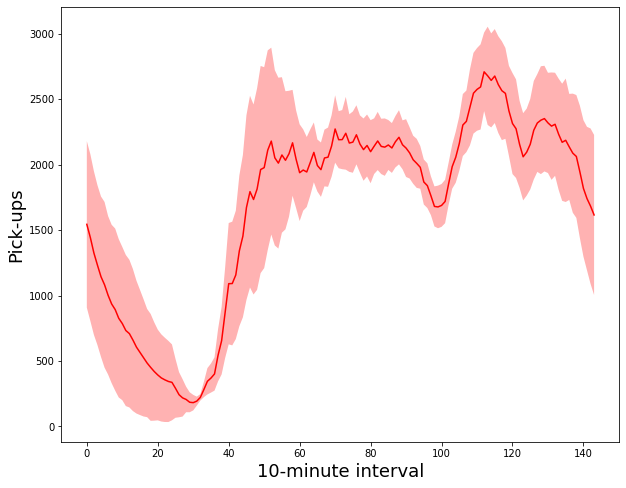

In [ ]:
fig = plt.figure(figsize=(10,8))
ax  = fig.gca()
ax.set_xlabel('10-minute interval', fontsize = 18)
ax.set_ylabel('Pick-ups', fontsize = 18)
xaxis = [t for t in range(144)]
# plt.errorbar(xaxis, tmeans, tstds, fmt='-r', linewidth=0.5, capsize=3)
ax.plot(xaxis, tmeans, c='red')
ax.fill_between(xaxis, tmeans-tstds, tmeans+tstds ,alpha=0.3, facecolor='red')
fig = plt.gcf()
plt.show()
fig.savefig('trips_t.png')

In [ ]:
tmeans.argmax(), tmeans.argmax()/6, tmeans.max()

(112, 18.666666666666668, 2708.733333333333)

In [ ]:
datecount = processed['start_datetime'].groupby([processed.start_datetime.dt.date]).agg('count')
datecount

start_datetime
2016-06-01    250397
2016-06-02    266378
2016-06-03    268252
2016-06-04    269833
2016-06-05    212889
2016-06-06    226970
2016-06-07    253859
2016-06-08    256123
2016-06-09    262856
2016-06-10    263506
2016-06-11    248662
2016-06-12    193785
2016-06-13    216124
2016-06-14    243554
2016-06-15    257548
2016-06-16    267012
2016-06-17    253002
2016-06-18    234055
2016-06-19    186996
2016-06-20    212656
2016-06-21    243280
2016-06-22    250597
2016-06-23    259930
2016-06-24    253269
2016-06-25    249117
2016-06-26    192859
2016-06-27    227107
2016-06-28    232037
2016-06-29    237241
2016-06-30    234121
Name: start_datetime, dtype: int64

In [ ]:
start_t_count = processed['start_t'].groupby([processed.start_t]).agg('count')
start_t_count

start_t
0      46314
1      43268
2      39736
3      36957
4      34308
       ...  
139    58321
140    54545
141    52219
142    50483
143    48462
Name: start_t, Length: 144, dtype: int64

### Run everything

In [ ]:
def get_mapped_int_matrix(city):
    '''
    Return mapped_int_matrix of city
    and `h3_map` - dict of {h3_id: mapped_int_matrix cell id}
    '''
    city_polygon_geojson = {
        'type': 'Polygon',
        'coordinates': [city['coords']]
    }
    bottom_left = city['bottom_left']
    M, N        = city['MN']
    res         = city['res']
    valid_hexs  = [* h3.polyfill(city_polygon_geojson, res=res)]

    mat = build_mat(valid_hexs, bottom_left, M, N)
    h3_map = h3_to_int(mat)
    mapped_int_matrix = np.array([[_h3_to_cell(mat[i][j], h3_map) for j in range(len(mat[0]))] for i in range(len(mat))])
    return mapped_int_matrix, h3_map

def _h3_to_cell(h3_id, h3_map):
    return h3_map[h3_id] if h3_id in h3_map else -1

def get_idle_driver_dist_time(procesed,T=144):
    day_t_count = processed.groupby([processed['start_datetime'].dt.date, 'start_t']).size()
    return [[day_t_count[:,t].mean(), day_t_count[:,t].std()] for t in range(T)]

def get_idle_driver_location_mat(processed,mapped_int_matrix,T=144):
    cell_ids=mapped_int_matrix[mapped_int_matrix>-1]
    cell_ids.sort()
    n_valid_cells=cell_ids.shape[0]
    idle_driver_location_mat = np.zeros((144, n_valid_cells))

    # Mean drivers at time t is calculated directly from data
    g=processed.groupby([processed['start_datetime'].dt.date,'start_t','start_cell']).size()
    for t in range(T):
        for cell_id in cell_ids:
            try:
                idle_driver_location_mat[t,cell_id] = g[:,t,cell_id].mean()
            except: pass
    idle_driver_location_mat[np.isnan(idle_driver_location_mat)]=0

    return idle_driver_location_mat

def get_order_real(processed):
    return np.array(processed[['start_cell', 'end_cell', 'start_t', 'duration', 'reward']].values.tolist())

def get_onoff_driver_location_matrix(processed,mapped_int_matrix,T=144):
    n_valid_cells=np.count_nonzero(mapped_int_matrix>-1)
    # All zeros bc no data
    onoff_driver_location_matrix=np.zeros((T,n_valid_cells,2))
    return onoff_driver_location_matrix

In [ ]:
processed=pd.read_pickle('nyc.2016-06.pkl')
processed.drop(processed[processed.duration>9].index,inplace=True)
processed.head()

,start_datetime,start_t,end_t,duration,start_h3,end_h3,start_cell,end_cell,reward
0,2016-06-09 21:06:36,126,127,1,882a100d65fffff,882a100d67fffff,77,89,7.30
2,2016-06-09 21:06:36,126,127,1,882a100d2dfffff,882a10721bfffff,88,98,9.36
4,2016-06-09 21:06:36,126,128,2,882a100d23fffff,882a100d65fffff,112,77,17.76
5,2016-06-09 21:06:36,126,127,1,882a100d27fffff,882a107259fffff,111,64,14.16
7,2016-06-09 21:06:37,126,127,1,882a100d2dfffff,882a100d65fffff,88,77,11.75


In [ ]:
mapped_int_matrix, h3_map = get_mapped_int_matrix(manhattan)
idle_driver_dist_time = get_idle_driver_dist_time(processed)
idle_driver_location_mat = get_idle_driver_location_mat(processed, mapped_int_matrix)
order_real = get_order_real(processed)
onoff_driver_location_matrix = get_onoff_driver_location_matrix(processed,mapped_int_matrix)

print('mapped_int_matrix:\n',mapped_int_matrix)
print('h3_map:\n', h3_map)
print('idle_driver_dist_time\n',idle_driver_dist_time)
print('idle_driver_location_mat:\n',idle_driver_location_mat)
print('order_real:\n',order_real)
print('onoff_driver_location_matrix:\n',onoff_driver_location_matrix)

mapped_int_matrix:
 [[-1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 11 12 13 -1]
 [-1 -1 -1 -1 -1 -1 12 13 14 15 16 17]
 [-1 -1 -1 -1 -1 -1 15 16 17 18 19 20]
 [-1 -1 -1 -1 16 17 18 19 20 21 22 -1]
 [-1 -1 -1 -1 19 20 21 22 23 24 -1 -1]
 [-1 -1 -1 21 22 23 24 25 26 27 -1 -1]
 [-1 -1 23 24 25 26 27 28 -1 -1 -1 -1]
 [-1 -1 26 27 28 29 30 31 -1 -1 -1 -1]
 [-1 28 29 30 31 32 33 -1 -1 -1 -1 -1]
 [-1 31 32 33 34 35 -1 -1 -1 -1 -1 -1]
 [33 34 35 36 37 -1 -1 -1 -1 -1 -1 -1]
 [36 37 38 39 40 -1 -1 -1 -1 -1 -1 -1]]
h3_map:
 {'882a1008c7fffff': 8, '882a100889fffff': 11, '882a1008c3fffff': 12, '882a1008ddfffff': 13, '882a100887fffff': 12, '882a100881fffff': 13, '882a10088bfffff': 14, '882a1008d5fffff': 15, '882a1008d1fffff': 16, '882a1008d9fffff': 17, '882a1008b9fffff': 15, '882a100883fffff': 16, '882a10089dfffff': 17, '882a1008d7fffff': 18, '882a1008d3fffff': 19, '882a1008dbfffff': 20, '882a1008b7fffff': 16, '882a1008b1fffff': 17, '882a1008bbfffff': 18, '882a100895fffff': 19, '88

In [ ]:
M,N         = manhattan['MN']
l_max       = min(M-1,N-1) # Maximum order duration, need to pass assertion l_max <= M-1 and l_max <= N-1
probability = 1/28 # The probability of each order in real_orders being sampled

env_data = {
    'mapped_int_matrix': mapped_int_matrix,
    'idle_driver_dist_time': idle_driver_dist_time,
    'idle_driver_location_mat': idle_driver_location_mat,
    'order_real': order_real,
    'onoff_driver_location_matrix': onoff_driver_location_matrix,
    'l_max': l_max,
    'MN': (M,N),
    'n_side': 6,
    'probability': probability
}
pkl.dump(env_data, open('env_data_lmax.pkl','wb'), protocol=pkl.HIGHEST_PROTOCOL)

# Model

## Utility

In [ ]:
import tensorflow as tf

import os
import errno

from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def ids_2dto1d(i, j, M, N):
    '''
    convert (i,j) in a M by N matrix to index in M*N list. (row wise)
    matrix: [[1,2,3], [4, 5, 6]]
    list: [0, 1, 2, 3, 4, 5, 6]
    index start from 0
    '''
    print('i:',i)
    print('j:',j)
    assert 0 <= i < M and 0 <= j < N
    index = i * N + j
    return int(index)


def ids_1dto2d(ids, M, N):
    ''' inverse of ids_2dto1d(i, j, M, N)
        index start from 0
    '''
    # i = np.floor(ids / N)
    i = int(ids / N)
    j = int(ids - N * i)
    return (i, j)


def get_neighbor_list(i, j, M, N, n, nodes):
    ''' n: n-sided polygon, construct for a 2d map
                 1
             6       2
               center
             5       3
                 4
    return index of neighbor 1, 2, 3, 4, 5,6 in the matrix
    '''

    neighbor_list = [None] * n
    if n == 6:
        # hexagonal
        if j % 2 == 0:
            if i - 1 >= 0:
                neighbor_list[0] = nodes[ids_2dto1d(i-1, j,   M, N)]
            if j + 1 < N:
                # print(ids_2dto1d(i,   j+1, M, N))
                neighbor_list[1] = nodes[ids_2dto1d(i,   j+1, M, N)]
            if i + 1 < M and j + 1 < N:
                # print(ids_2dto1d(i+1,j+1,M,N))
                neighbor_list[2] = nodes[ids_2dto1d(i+1, j+1, M, N)]
            if i + 1 < M:
                neighbor_list[3] = nodes[ids_2dto1d(i+1, j,   M, N)]
            if i + 1 < M and j - 1 >= 0:
                neighbor_list[4] = nodes[ids_2dto1d(i+1, j-1, M, N)]
            if j - 1 >= 0:
                neighbor_list[5] = nodes[ids_2dto1d(i,   j-1, M, N)]
        elif j % 2 == 1:
            if i - 1 >= 0:
                neighbor_list[0] = nodes[ids_2dto1d(i-1, j,   M, N)]
            if i - 1 >= 0 and j + 1 < N:
                neighbor_list[1] = nodes[ids_2dto1d(i-1, j+1, M, N)]
            if j + 1 < N:
                neighbor_list[2] = nodes[ids_2dto1d(i,   j+1, M, N)]
            if i + 1 < M:
                neighbor_list[3] = nodes[ids_2dto1d(i+1, j,   M, N)]
            if j - 1 >= 0:
                neighbor_list[4] = nodes[ids_2dto1d(i,   j-1, M, N)]
            if i - 1 >= 0 and j - 1 >= 0:
                neighbor_list[5] = nodes[ids_2dto1d(i-1, j-1, M, N)]
    elif n == 4:
        # square
        if i - 1 >= 0:
            neighbor_list[0] = nodes[ids_2dto1d(i-1, j,   M, N)]
        if j + 1 < N:
            neighbor_list[1] = nodes[ids_2dto1d(i,   j+1, M, N)]
        if i + 1 < M:
            neighbor_list[2] = nodes[ids_2dto1d(i+1, j,   M, N)]
        if j - 1 >= 0:
            neighbor_list[3] = nodes[ids_2dto1d(i,   j-1, M, N)]

    return neighbor_list


def get_neighbor_index(i, j):
    """
                 1
             6       2
                center
             5       3
                 4
    return index of neighbor 1, 2, 3, 4, 5, 6 in the matrix
    """
    neighbor_matrix_ids = []
    if j % 2 == 0:
        neighbor_matrix_ids = [[i - 1, j    ],
                               [i,     j + 1],
                               [i + 1, j + 1],
                               [i + 1, j    ],
                               [i + 1, j - 1],
                               [i    , j - 1]]
    elif j % 2 == 1:
        neighbor_matrix_ids = [[i - 1, j    ],
                               [i - 1, j + 1],
                               [i    , j + 1],
                               [i + 1, j    ],
                               [i    , j - 1],
                               [i - 1, j - 1]]

    return neighbor_matrix_ids


def get_layers_neighbors(i, j, l_max, M, N):
    """get neighbors of node layer by layer, todo BFS.
       i, j: center node location
       L_max: max number of layers
       layers_neighbors: layers_neighbors[0] first layer neighbor: 6 nodes: can arrived in 1 time step.
       layers_neighbors[1]: 2nd layer nodes id
       M, N: matrix rows and columns.
    """
    assert l_max >= 1
    layers_neighbors = []

    layer1_neighbor = get_neighbor_index(i, j)  #[[1,1], [0, 1], ...]
    # temp = [[x,y] for x,y in layer1_neighbor if 0 <= x <= M-1 and 0 <= y <= N-1] # valid neighbors
    node_id_neighbors = []
    temp = []
    for x, y in layer1_neighbor:
        if 0 <= x <= M-1 and 0 <= y <= N-1:
            temp.append([x, y])
            node_id_neighbors.append(ids_2dto1d(x, y, M, N))
    layers_neighbors.append(temp)

    # for item in layer1_neighbor:
    #     x, y = item
    #     if 0 <= x <= M-1 and 0 <= y <= N-1:
    #         node_id_neighbors.append(ids_2dto1d(x, y, M, N))

    layers_neighbors_set = set(node_id_neighbors)
    cur_node_id = ids_2dto1d(i, j, M, N)
    layers_neighbors_set.add(cur_node_id)

    t = 1
    while t < l_max:
        t += 1
        layer_neighbor_temp = []
        for item in layers_neighbors[-1]:
            x, y = item
            if 0 <= x <= M-1 and 0 <= y <= N-1:
                layer_neighbor_temp += get_neighbor_index(x, y)

        layer_neighbor = []  # remove previous layer neighbors
        for item in layer_neighbor_temp:
            x, y = item
            if 0 <= x <= M-1 and 0 <= y <= N-1:
                node_id = ids_2dto1d(x, y, M, N)
                if node_id not in layers_neighbors_set:
                    layer_neighbor.append(item)
                    layers_neighbors_set.add(node_id)
        layers_neighbors.append(layer_neighbor)

    return layers_neighbors


def get_driver_status(env):
    idle_driver_dist = np.zeros((env.M, env.N))
    for driver_id, cur_drivers in env.drivers.iteritems():
        if cur_drivers.node is not None:
            node_id = cur_drivers.node.get_node_index()
            row, col = ids_1dto2d(node_id, env.M, env.N)
            if cur_drivers.onservice is False and cur_drivers.online is True:
                idle_driver_dist[row, col] += 1

    return idle_driver_dist

def debug_print_drivers(node):
    print("Status of all drivers in the node {}".format(node.get_node_index()))
    print("|{:12}|{:12}|{:12}|{:12}|".format("driver id", "driver location", "online", "onservice"))

    for driver_id, cur_drivers in node.drivers.iteritems():
        if cur_drivers.node is not None:
            node_id = cur_drivers.node.get_node_index()
        else:
            node_id = "none"
        print("|{:12}|{:12}|{:12}|{:12}|".format(driver_id, node_id, cur_drivers.online, cur_drivers.onservice))


""" Some of Following codes are modified from https://github.com/openai/baselines
"""
def tfsum(x, axis=None, keepdims=False):
    axis = None if axis is None else [axis]
    return tf.reduce_sum(x, axis=axis, keepdims=keepdims)

class Pd(object):
    """
    A particular probability distribution
    """

    def mode(self):
        raise NotImplementedError

    def neglogp(self, x):
        # Usually it's easier to define the negative logprob
        raise NotImplementedError

    def kl(self, other):
        raise NotImplementedError

    def entropy(self):
        raise NotImplementedError

    def sample(self):
        raise NotImplementedError

    def logp(self, x):
        return - self.neglogp(x)


class DiagGaussianPd(Pd):
    def __init__(self, mu, logstd):
        self.mean = mu
        self.logstd = logstd
        self.std = tf.exp(logstd)

    def mode(self):
        return self.mean

    def neglogp(self, x):
        # axis = -1, sum over last dimension, first dimension is batch size
        return 0.5 * tfsum(tf.square((x - self.mean) / self.std), axis=-1) \
               + 0.5 * np.log(2.0 * np.pi) * tf.to_float(tf.shape(x)[-1]) \
               + tfsum(self.logstd, axis=-1)

    def sample(self):
        return self.mean + self.std * tf.random_normal(tf.shape(self.mean))



def normalize_reward(discounted_epr):
    reward_mean = np.mean(discounted_epr)
    reward_std  = np.std(discounted_epr)
    discounted_epr = (discounted_epr - reward_mean)/reward_std
    return discounted_epr

# def projection(Y, n, num_idle_driver):
#     assert np.sum(Y) > num_idle_driver
#     X = cvx.Variable(n)
#     objective = cvx.Minimize(cvx.sum_squares(X - Y))
#     constraints = [0 <= X,
#                    num_idle_driver == cvx.sum_entries(X)]
#     prob = cvx.Problem(objective, constraints)
#
#     # The optimal objective is returned by prob.solve().
#     result = prob.solve()
#     return X.value


def continuous_quadratic_knapsack(b, u, r):
    """
    OBJECTIVE
     min 1/2*||x||_2^2
     s.t. b'*x = r, 0<= x <= u,  b > 0

    Related paper
     [1] KC. Kiwiel. On linear-time algorithms for the continuous
         quadratic knapsack problem, Journal of Optimization Theory
         and Applications, 2007
    Coding Reference:
    https://github.com/jiayuzhou/MALSAR/blob/master/MALSAR/functions/CMTL/bsa_ihb.m
    """
    n = len(b)
    break_flag = 0
    t_l = np.zeros(n)
    t_u = -u    # ( 0 - u)/1
    t_L = -float('Inf')
    t_U = float('Inf')
    g_tL = 0
    g_tU = 0
    T = np.concatenate((t_l, t_u), axis=0)
    n_iter = 0
    while len(T) !=0:
        n_iter += 1
        g_t = 0
        t_hat = np.median(T)

        U_inds = np.where(t_hat < t_u)
        M      = np.where((t_u <= t_hat) & (t_hat <= t_l))

        if len(U_inds[0]) != 0:
            g_t = g_t  + np.dot(b[U_inds], u[U_inds])

        if len(M[0]) != 0:
            g_t = g_t - np.dot(b[M], t_hat*b[M])  # a = 0   np.sum(b(M).*(a(M) - t_hat*b(M)))
        if g_t > r:
            t_L = t_hat
            T = T[np.where(T > t_hat)]
            g_tL = g_t
        elif g_t < r:
            t_U = t_hat
            T = T[np.where(T < t_hat)]
            g_tU = g_t
        else:
            t_star = t_hat
            break_flag = 1
            break

    if break_flag == 0:
         t_star = t_L - (g_tL -r)*(t_U - t_L)/(g_tU - g_tL)
    x_star = np.minimum(np.maximum(0, -t_star*b), u)
    return x_star


def projection_fast(u, n, num_idle_driver):
    b = np.ones((n))
    r = np.sum(u) - num_idle_driver
    x_star = continuous_quadratic_knapsack(b, u, r)
    return u - x_star


def categorical_sample_split(logits, d=6):
    """
    :param logits: sampling according to the probability exp(logits)
    :param d: first dimension of logits. 6 in our case.
    :return:
    """

    value = [tf.multinomial(logits[i] - tf.reduce_max(logits[i], [1], keep_dims=True), 1)
             for i in np.arange(d)
             ]
    return value

def fc(x, scope, nh, act=tf.nn.relu, init_scale=1.0):
    # with tf.variable_scope(scope):
    with tf.compat.v1.variable_scope(scope):
        # nin = x.get_shape()[1].value
        nin = x.get_shape()[1]
        # w = tf.get_variable("w", [nin, nh], initializer=ortho_init(init_scale))
        w = tf.get_variable("w", [nin, nh], initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=0))
        b = tf.get_variable("b", [nh], initializer=tf.constant_initializer(0.0))
        z = tf.matmul(x, w)+b
        h = act(z)
        return h


def ortho_init(scale=1.0):
    def _ortho_init(shape, dtype, partition_info=None):
        #lasagne ortho init for tf
        shape = tuple(shape)
        if len(shape) == 2:
            flat_shape = shape
        elif len(shape) == 4: # assumes NHWC
            flat_shape = (np.prod(shape[:-1]), shape[-1])
        else:
            raise NotImplementedError
        np.random.seed(1)
        a = np.random.normal(0.0, 1.0, flat_shape)
        u, _, v = np.linalg.svd(a, full_matrices=False)
        q = u if u.shape == flat_shape else v # pick the one with the correct shape
        q = q.reshape(shape)
        return (scale * q[:shape[0], :shape[1]]).astype(np.float32)
    return _ortho_init


##############################################################
### utility function for tune DQN
##############################################################

def get_target_ids_local(mapped_matrix_int_local):
    row_inds, col_inds = np.where(mapped_matrix_int_local >= 0)

    M_local, N_local = mapped_matrix_int_local.shape
    target_ids_local  = []  # start from 0.
    for x, y in zip(row_inds, col_inds):
        node_id = ids_2dto1d(x, y, M_local, N_local)
        target_ids_local.append(node_id)
    return target_ids_local

def collision_action(action_tuple):
    count = 0
    action_set = set(())
    for item in action_tuple:
        if item[1] == -1:
            continue
        grid_id_key = str(item[0]) + "-" + str(item[1])
        action_set.add(grid_id_key)
        conflict_id_key = str(item[1]) + "-" + str(item[0])
        if conflict_id_key in action_set:
            count += 1
    return count

def construct_grid_nodeid_mapping(target_ids_local, grid_ids_local):
    node_mapping = {}
    grid_mapping = {} #
    for nodeid, gridid in zip(target_ids_local, grid_ids_local):
        node_mapping[gridid] = nodeid
        grid_mapping[nodeid] = gridid
    return node_mapping, grid_mapping

def utility_conver_states(curr_s, target_id_states):
    curr_s_new = [curr_s[idx] for idx in target_id_states]
    return np.array(curr_s_new)

def utility_conver_reward(reward_node, target_id_states):
    reward_node_new = [reward_node[idx] for idx in target_id_states]
    return np.array(reward_node_new)

##############################################################


def compute_sum_qtable(temp_qtable):
    temp_q = 0
    for item in temp_qtable:
        for jj in item:
            temp_q += np.sum(jj)

    return temp_q

## Environment

### Node, Driver, Order

In [ ]:
import numpy as np
from abc import ABCMeta, abstractmethod

class Distribution():
    ''' Define the distribution from which sample the orders'''
    __metaclass__ = ABCMeta  # python 2.7
    @abstractmethod
    def sample(self):
        pass

class PoissonDistribution(Distribution):

    def __init__(self, lam):
        self._lambda = lam

    def sample(self, seed=0):
        np.random.seed(seed)
        return np.random.poisson(self._lambda, 1)[0]


class GaussianDistribution(Distribution):

    def __init__(self, args):
        mu, sigma = args
        self.mu = mu        # mean
        self.sigma = sigma  # standard deviation

    def sample(self, seed=0):
        np.random.seed(seed)
        return np.random.normal(self.mu, self.sigma, 1)[0]


class Node(object):
    __slots__ = ('neighbors', '_index', 'orders', 'drivers',
                 'order_num', 'idle_driver_num', 'offline_driver_num'
                 'order_generator', 'offline_driver_num', 'order_generator',
                 'n_side', 'layers_neighbors', 'layers_neighbors_id')

    def __init__(self, index):
        # private
        self._index = index   # unique node index.

        # public
        self.neighbors = []  # a list of nodes that neighboring the Nodes
        self.orders = []     # a list of orders
        self.drivers = {}    # a dictionary of driver objects contained in this node
        self.order_num = 0
        self.idle_driver_num = 0  # number of idle drivers in this node
        self.offline_driver_num = 0
        self.order_generator = None

        self.n_side = 0      # the topology is a n-sided map
        self.layers_neighbors = []  # layer 1 indices: layers_neighbors[0] = [[1,1], [0, 1], ...],
        # layer 2 indices layers_neighbors[1]
        self.layers_neighbors_id = [] # layer 1: layers_neighbors_id[0] = [2, 1,.]

    def clean_node(self):
        self.orders = []
        self.order_num = 0
        self.drivers = {}
        self.idle_driver_num = 0
        self.offline_driver_num = 0

    def get_layers_neighbors(self, l_max, M, N, env):

        x, y = ids_1dto2d(self.get_node_index(), M, N)
        self.layers_neighbors = get_layers_neighbors(x, y, l_max, M, N)
        for layer_neighbors in self.layers_neighbors:
            temp = []
            for item in layer_neighbors:
                x, y = item
                node_id = ids_2dto1d(x, y, M, N)
                if env.nodes[node_id] is not None:
                    temp.append(node_id)
            self.layers_neighbors_id.append(temp)

    def get_node_index(self):
        return self._index

    def get_driver_numbers(self):
        return self.idle_driver_num

    def get_idle_driver_numbers_loop(self):
        temp_idle_driver = 0
        for key, driver in self.drivers.items():
            if driver.onservice is False and driver.online is True:
                temp_idle_driver += 1
        return temp_idle_driver

    def get_off_driver_numbers_loop(self):
        temp_idle_driver = 0
        for key, driver in self.drivers.items():
            if driver.onservice is False and driver.online is False:
                temp_idle_driver += 1
        return temp_idle_driver

    def order_distribution(self, distribution, dis_paras):

        if distribution == 'Poisson':
            self.order_generator = PoissonDistribution(dis_paras)
        elif distribution == 'Gaussian':
            self.order_generator = GaussianDistribution(dis_paras)
        else:
            pass

    def generate_order_random(self, city_time, nodes, seed):
        """Generate new orders at each time step
        """
        num_order_t = self.order_generator.sample(seed)
        self.order_num += num_order_t

        for ii in np.arange(num_order_t):
            price = np.random.normal(50, 5, 1)[0]
            price = 10 if price < 0 else price

            current_node_id = self.get_node_index()
            destination_node = [kk for kk in np.arange(len(nodes)) if kk != current_node_id]
            self.orders.append(Order(nodes[current_node_id],
                                     nodes[np.random.choice(destination_node, 1)[0]],
                                     city_time,
                                     # city_time + np.random.choice(5, 1)[0]+1,
                                     np.random.choice(2, 1)[0]+1,  # duration
                                     price, 1))
        return

    def generate_order_real(self, l_max, order_time_dist, order_price_dist, city_time, nodes, seed):
        """Generate new orders at each time step
        """
        num_order_t = self.order_generator.sample(seed)
        self.order_num += num_order_t
        for ii in np.arange(num_order_t):

            if l_max == 1:
                duration = 1
            else:

                duration = np.random.choice(np.arange(1, l_max+1), p=order_time_dist)
            price_mean, price_std = order_price_dist[duration-1]
            price = np.random.normal(price_mean, price_std, 1)[0]
            price = price if price > 0 else price_mean

            current_node_id = self.get_node_index()
            destination_node = []
            for jj in np.arange(duration):
                for kk in self.layers_neighbors_id[jj]:
                    if nodes[kk] is not None:
                        destination_node.append(kk)
            self.orders.append(Order(nodes[current_node_id],
                                     nodes[np.random.choice(destination_node, 1)[0]],
                                     city_time,
                                     duration,
                                     price, 1))
        return

    def add_order_real(self, city_time, destination_node, duration, price):
        current_node_id = self.get_node_index()
        self.orders.append(Order(self,
                                 destination_node,
                                 city_time,
                                 duration,
                                 price, 0))
        self.order_num += 1

    def set_neighbors(self, nodes_list):
        self.neighbors = nodes_list
        self.n_side = len(nodes_list)

    def remove_idle_driver_random(self):
        """Randomly remove one idle driver from current grid"""
        removed_driver_id = "NA"
        for key, item in self.drivers.items():
            if item.onservice is False and item.online is True:
                self.remove_driver(key)
                removed_driver_id = key
            if removed_driver_id != "NA":
                break
        assert removed_driver_id != "NA"
        return removed_driver_id

    def set_idle_driver_offline_random(self):
        """Randomly set one idle driver offline"""
        removed_driver_id = "NA"
        for key, item in self.drivers.items():
            if item.onservice is False and item.online is True:
                item.set_offline()
                removed_driver_id = key
            if removed_driver_id != "NA":
                break
        assert removed_driver_id != "NA"
        return removed_driver_id

    def set_offline_driver_online(self):

        online_driver_id = "NA"
        for key, item in self.drivers.items():
            if item.onservice is False and item.online is False:
                item.set_online()
                online_driver_id = key
            if online_driver_id != "NA":
                break
        assert online_driver_id != "NA"
        return online_driver_id

    def get_driver_random(self):
        """Randomly get one driver"""
        assert self.idle_driver_num > 0
        get_driver_id = 0
        for key in self.drivers.iterkeys():
            get_driver_id = key
            break
        return self.drivers[get_driver_id]

    def remove_driver(self, driver_id):

        removed_driver = self.drivers.pop(driver_id, None)
        self.idle_driver_num -= 1
        if removed_driver is None:
            raise ValueError('Nodes.remove_driver: Remove a driver that is not in this node')

        return removed_driver

    def add_driver(self, driver_id, driver):
        self.drivers[driver_id] = driver
        self.idle_driver_num += 1

    def remove_unfinished_order(self, city_time):
        un_finished_order_index = []
        for idx, o in enumerate(self.orders):
            # order un served
            if o.get_wait_time()+o.get_begin_time() < city_time:
                un_finished_order_index.append(idx)

            # order completed
            if o.get_assigned_time() + o.get_duration() == city_time and o.get_assigned_time() != -1:
                un_finished_order_index.append(idx)

        if len(un_finished_order_index) != 0:
            # remove unfinished orders
            self.orders = [i for j, i in enumerate(self.orders) if j not in un_finished_order_index]
            self.order_num = len(self.orders)

    def simple_order_assign(self, city_time, city):
        reward = 0
        num_assigned_order = min(self.order_num, self.idle_driver_num)
        served_order_index = []
        for idx in np.arange(num_assigned_order):
            order_to_serve = self.orders[idx]
            order_to_serve.set_assigned_time(city_time)
            self.order_num -= 1
            reward += order_to_serve.get_price()
            served_order_index.append(idx)
            for key, assigned_driver in self.drivers.items():
                if assigned_driver.onservice is False and assigned_driver.online is True:
                    assigned_driver.take_order(order_to_serve)
                    removed_driver = self.drivers.pop(assigned_driver.get_driver_id(), None)
                    assert removed_driver is not None
                    city.n_drivers -= 1
                    break

        all_order_num = len(self.orders)
        finished_order_num = len(served_order_index)

        # remove served orders
        self.orders = [i for j, i in enumerate(self.orders) if j not in served_order_index]
        assert self.order_num == len(self.orders)

        return reward, all_order_num, finished_order_num

    def simple_order_assign_real(self, city_time, city):

        reward = 0
        num_assigned_order = min(self.order_num, self.idle_driver_num)
        served_order_index = []
        for idx in np.arange(num_assigned_order):
            order_to_serve = self.orders[idx]
            order_to_serve.set_assigned_time(city_time)
            self.order_num -= 1
            reward += order_to_serve.get_price()
            served_order_index.append(idx)
            for key, assigned_driver in self.drivers.items():
                if assigned_driver.onservice is False and assigned_driver.online is True:
                    if order_to_serve.get_end_position() is not None:
                        assigned_driver.take_order(order_to_serve)
                        removed_driver = self.drivers.pop(assigned_driver.get_driver_id(), None)
                        assert removed_driver is not None
                    else:
                        assigned_driver.set_offline()  # order destination is not in target region
                    city.n_drivers -= 1
                    break

        all_order_num = len(self.orders)
        finished_order_num = len(served_order_index)

        # remove served orders
        self.orders = [i for j, i in enumerate(self.orders) if j not in served_order_index]
        assert self.order_num == len(self.orders)

        return reward, all_order_num, finished_order_num


    def simple_order_assign_broadcast_update(self, city, neighbor_node_reward):

        assert self.idle_driver_num == 0
        reward = 0
        num_finished_orders = 0
        for neighbor_node in self.neighbors:
            if neighbor_node is not None and neighbor_node.idle_driver_num > 0:
                num_assigned_order = min(self.order_num, neighbor_node.idle_driver_num)
                rr = self.utility_assign_orders_neighbor(city, neighbor_node, num_assigned_order)
                reward += rr
                neighbor_node_reward[neighbor_node.get_node_index()] += rr
                num_finished_orders += num_assigned_order
            if self.order_num == 0:
                break

        assert self.order_num == len(self.orders)
        return reward, num_finished_orders

    def utility_assign_orders_neighbor(self, city, neighbor_node, num_assigned_order):

        served_order_index = []
        reward = 0
        curr_city_time = city.city_time
        for idx in np.arange(num_assigned_order):
            order_to_serve = self.orders[idx]
            order_to_serve.set_assigned_time(curr_city_time)
            self.order_num -= 1
            reward += order_to_serve.get_price()
            served_order_index.append(idx)
            for key, assigned_driver in neighbor_node.drivers.items():
                if assigned_driver.onservice is False and assigned_driver.online is True:
                    if order_to_serve.get_end_position() is not None:
                        assigned_driver.take_order(order_to_serve)
                        removed_driver = neighbor_node.drivers.pop(assigned_driver.get_driver_id(), None)
                        assert removed_driver is not None
                    else:
                        assigned_driver.set_offline()
                    city.n_drivers -= 1
                    break

        # remove served orders
        self.orders = [i for j, i in enumerate(self.orders) if j not in served_order_index]
        assert self.order_num == len(self.orders)

        return reward


class Driver(object):
    __slots__ = ("online", "onservice", 'order', 'node', 'city_time', '_driver_id')

    def __init__(self, driver_id):
        self.online = True
        self.onservice = False
        self.order = None     # the order this driver is serving
        self.node = None      # the node that contain this driver.
        self.city_time = 0  # track the current system time

        # private
        self._driver_id = driver_id  # unique driver id.

    def set_position(self, node):
        self.node = node

    def set_order_start(self, order):
        self.order = order

    def set_order_finish(self):
        self.order = None
        self.onservice = False

    def get_driver_id(self):
        return self._driver_id

    def update_city_time(self):
        self.city_time += 1

    def set_city_time(self, city_time):
        self.city_time = city_time

    def set_offline(self):
        assert self.onservice is False and self.online is True
        self.online = False
        self.node.idle_driver_num -= 1
        self.node.offline_driver_num += 1

    def set_offline_for_start_dispatch(self):

        assert self.onservice is False
        self.online = False

    def set_online(self):
        assert self.onservice is False
        self.online = True
        self.node.idle_driver_num += 1
        self.node.offline_driver_num -= 1

    def set_online_for_finish_dispatch(self):

        self.online = True
        assert self.onservice is False

    def take_order(self, order):
        """ take order, driver show up at destination when order is finished
        """
        assert self.online == True
        self.set_order_start(order)
        self.onservice = True
        self.node.idle_driver_num -= 1

    def status_control_eachtime(self, city):

        assert self.city_time == city.city_time
        if self.onservice is True:
            assert self.online is True
            order_end_time = self.order.get_assigned_time() + self.order.get_duration()
            if self.city_time == order_end_time:
                self.set_position(self.order.get_end_position())
                self.set_order_finish()
                self.node.add_driver(self._driver_id, self)
                city.n_drivers += 1
            elif self.city_time < order_end_time:
                pass
            else:
                raise ValueError('Driver: status_control_eachtime(): order end time less than city time')


class Order(object):
    __slots__ = ('_begin_p', '_end_p', '_begin_t',
                 '_t', '_p', '_waiting_time', '_assigned_time')

    def __init__(self, begin_position, end_position, begin_time, duration, price, wait_time):
        self._begin_p = begin_position  # node
        self._end_p = end_position      # node
        self._begin_t = begin_time
        # self._end_t = end_time
        self._t = duration              # the duration of order.
        self._p = price
        self._waiting_time = wait_time  # a order can last for "wait_time" to be taken
        self._assigned_time = -1

    def get_begin_position(self):
        return self._begin_p

    def get_begin_position_id(self):
        return self._begin_p.get_node_index()

    def get_end_position(self):
        return self._end_p

    def get_begin_time(self):
        return self._begin_t

    def set_assigned_time(self, city_time):
        self._assigned_time = city_time

    def get_assigned_time(self):
        return self._assigned_time

    # def get_end_time(self):
    #     return self._end_t

    def get_duration(self):
        return self._t

    def get_price(self):
        return self._p

    def get_wait_time(self):
        return self._waiting_time


### Order

In [ ]:
class Order(object):
    __slots__ = ('_begin_p', '_end_p', '_begin_t',
                 '_t', '_p', '_waiting_time', '_assigned_time')

    def __init__(self, begin_position, end_position, begin_time, duration, price, wait_time):
        self._begin_p = begin_position  # node
        self._end_p = end_position      # node
        self._begin_t = begin_time
        # self._end_t = end_time
        self._t = duration              # the duration of order.
        self._p = price
        self._waiting_time = wait_time  # a order can last for "wait_time" to be taken
        self._assigned_time = -1

    def get_begin_position(self):
        return self._begin_p

    def get_begin_position_id(self):
        return self._begin_p.get_node_index()

    def get_end_position(self):
        return self._end_p

    def get_begin_time(self):
        return self._begin_t

    def set_assigned_time(self, city_time):
        self._assigned_time = city_time

    def get_assigned_time(self):
        return self._assigned_time

    # def get_end_time(self):
    #     return self._end_t

    def get_duration(self):
        return self._t

    def get_price(self):
        return self._p

    def get_wait_time(self):
        return self._waiting_time


### City

In [ ]:
import random, time
import logging
sys.path.append("../")

# from simulator.objects import *
# from simulator.utilities import *
# from algorithm import *

# current_time = time.strftime("%Y%m%d_%H-%M")
# log_dir = "/nfs/private/linkaixiang_i/data/dispatch_simulator/experiments/"+current_time + "/"
# mkdir_p(log_dir)
# logging.basicConfig(filename=log_dir +'logger_env.log', level=logging.INFO)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger_ch = logging.StreamHandler()
logger_ch.setLevel(logging.DEBUG)
logger_ch.setFormatter(logging.Formatter(
    '%(asctime)s[%(levelname)s][%(lineno)s:%(funcName)s]||%(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'))
logger.addHandler(logger_ch)
RANDOM_SEED = 0  # unit test use this random seed.

class CityReal:
    '''A real city is consists of M*N grids '''

    def __init__(self, mapped_matrix_int, order_num_dist, idle_driver_dist_time, idle_driver_location_mat, order_time_dist, order_price_dist,
                 l_max, M, N, n_side=6, probability=1.0/28, real_orders="", onoff_driver_location_mat="",
                 global_flag="global", time_interval=10):
        """
        :param mapped_matrix_int: 2D matrix: each position is either -100 or grid id from order in real data.
        :param order_num_dist: 144 [{node_id1: [mu, std]}, {node_id2: [mu, std]}, ..., {node_idn: [mu, std]}]
                            node_id1 is node the index in self.nodes
        :param idle_driver_dist_time: [[mu1, std1], [mu2, std2], ..., [mu144, std144]] mean and variance of idle drivers in
        the city at each time
        :param idle_driver_location_mat: 144 x num_valid_grids matrix.
        :param order_time_dist: [ 0.27380797,..., 0.00205766] The probs of order duration = 1 to 9
        :param order_price_dist: [[10.17, 3.34],   # mean and std of order's price, order durations = 10 minutes.
                                   [15.02, 6.90],  # mean and std of order's price, order durations = 20 minutes.
                                   ...,]
        :param onoff_driver_location_mat: 144 x 504 x 2: 144 total time steps, num_valid_grids = 504.
        mean and std of online driver number - offline driver number
        onoff_driver_location_mat[t] = [[-0.625       2.92350389]  <-- Corresponds to the grid in target_node_ids
                                        [ 0.09090909  1.46398452]
                                        [ 0.09090909  2.36596622]
                                        [-1.2         2.05588586]...]
        :param M:
        :param N:
        :param n_side:
        :param time_interval:
        :param l_max: The max-duration of an order
        :return:
        """
        # City.__init__(self, M, N, n_side, time_interval)
        self.M = M  # row numbers
        self.N = N  # column numbers
        # self.nodes = [Node(i) for i in range(M * N)]  # a list of nodes: node id start from 0
        self.nodes = [Node(i) for i in range(M*N)]  # a list of nodes: node id start from 0
        self.drivers = {}  # driver[driver_id] = driver_instance  , driver_id start from 0
        self.n_drivers = 0  # total idle number of drivers. online and not on service.
        self.n_offline_drivers = 0  # total number of offline drivers.
        self.construct_map_simulation(M, N, n_side)
        self.city_time = 0
        # self.idle_driver_distribution = np.zeros((M, N))
        # self.n_intervals = 1440 / time_interval
        self.n_intervals = int(1440 / time_interval)
        self.n_nodes = self.M * self.N
        self.n_side = n_side
        self.order_response_rate = 0

        self.RANDOM_SEED = RANDOM_SEED

        self.l_max = l_max  # Start from 1. The max number of layers an order can across.
        assert l_max <= M-1 and l_max <= N-1
        # assert 1 <= l_max <= 9   # Ignore orders less than 10 minutes and larger than 1.5 hours

        self.target_grids = []
        self.n_valid_grids = 0  # num of valid grid
        self.nodes = [None for _ in range(self.M*self.N)]
        self.construct_node_real(mapped_matrix_int)
        self.mapped_matrix_int = mapped_matrix_int

        self.construct_map_real(n_side)
        self.order_num_dist = order_num_dist
        self.distribution_name = "Poisson"
        self.idle_driver_dist_time = idle_driver_dist_time
        self.idle_driver_location_mat = idle_driver_location_mat

        self.order_time_dist = order_time_dist[:l_max]/np.sum(order_time_dist[:l_max])
        self.order_price_dist = order_price_dist

        target_node_ids = []
        target_grids_sorted = np.sort(mapped_matrix_int[np.where(mapped_matrix_int > 0)])
        for item in target_grids_sorted:
            x, y = np.where(mapped_matrix_int == item)
            # target_node_ids.append(ids_2dto1d(x, y, M, N)[0])
            target_node_ids.append(ids_2dto1d(x, y, M, N))
        self.target_node_ids = target_node_ids
        # store valid note id. Sort by number of orders emerged. descending.

        self.node_mapping = {}
        self.construct_mapping()

        self.real_orders = real_orders  # 4 weeks' data
        # [[92, 300, 143, 2, 13.2],...] origin grid, destination grid, start time, end time, price.


        self.p = probability   # sample probability
        self.time_keys = [int(dt.strftime('%H%M')) for dt in
                          datetime_range(datetime(2017, 9, 1, 0), datetime(2017, 9, 2, 0),
                                        timedelta(minutes=time_interval))]
        self.day_orders = []  # one day's order.

        self.onoff_driver_location_mat = onoff_driver_location_mat

        # Stats
        self.all_grids_on_number = 0  # current online # drivers.
        self.all_grids_off_number = 0

        # print(self.n_intervals)
        self.out_grid_in_orders = np.zeros((self.n_intervals, len(self.target_grids)))
        self.global_flag = global_flag
        self.weights_layers_neighbors = [1.0, np.exp(-1), np.exp(-2)]


    def construct_map_simulation(self, M, N, n):
        """Connect node to its neighbors based on a simulated M by N map
            :param M: M row index matrix
            :param N: N column index matrix
            :param n: n - sided polygon
        """
        for idx, current_node in enumerate(self.nodes):
            if current_node is not None:
                i, j = ids_1dto2d(idx, M, N)
                current_node.set_neighbors(get_neighbor_list(i, j, M, N, n, self.nodes))

    def construct_mapping(self):
        """
        :return:
        """
        target_grid_id = self.mapped_matrix_int[np.where(self.mapped_matrix_int>0)]
        for g_id, n_id in zip(target_grid_id, self.target_grids):
            self.node_mapping[g_id] = n_id

    def construct_node_real(self, mapped_matrix_int):
        """
        Initialize node, only valid node in mapped_matrix_in will be initialized.
        """
        row_inds, col_inds = np.where(mapped_matrix_int >= 0)

        target_ids = []  # start from 0.
        for x, y in zip(row_inds, col_inds):
            node_id = ids_2dto1d(x, y, self.M, self.N)
            self.nodes[node_id] = Node(node_id)  # node id start from 0.
            target_ids.append(node_id)

        for x, y in zip(row_inds, col_inds):
            node_id = ids_2dto1d(x, y, self.M, self.N)
            self.nodes[node_id].get_layers_neighbors(self.l_max, self.M, self.N, self)

        self.target_grids = target_ids
        self.n_valid_grids = len(target_ids)

    def construct_map_real(self, n_side):
        """Build node connection.
        """
        for idx, current_node in enumerate(self.nodes):
            i, j = ids_1dto2d(idx, self.M, self.N)
            if current_node is not None:
                current_node.set_neighbors(get_neighbor_list(i, j, self.M, self.N, n_side, self.nodes))

    def initial_order_random(self, distribution_all, dis_paras_all):
        """ Initialize order distribution
        :param distribution: 'Poisson', 'Gaussian'
        :param dis_paras:     lambda,    mu, sigma
        """
        for idx, node in enumerate(self.nodes):
            if node is not None:
                node.order_distribution(distribution_all[idx], dis_paras_all[idx])

    def get_observation(self):
        next_state = np.zeros((2, self.M, self.N))
        for _node in self.nodes:
            if _node is not None:
                row_id, column_id = ids_1dto2d(_node.get_node_index(), self.M, self.N)
                # print(row_id, column_id)
                next_state[0, row_id, column_id] = _node.idle_driver_num
                next_state[1, row_id, column_id] = _node.order_num

        # print('next_state.shape:', next_state.shape)
        return next_state

    def get_num_idle_drivers(self):
        """ Compute idle drivers
        :return:
        """
        temp_n_idle_drivers= 0
        for _node in self.nodes:
            if _node is not None:
                temp_n_idle_drivers += _node.idle_driver_num
        return temp_n_idle_drivers

    def get_observation_driver_state(self):
        """ Get idle driver distribution, computing #drivers from node.
        :return:
        """
        next_state = np.zeros((self.M, self.N))
        for _node in self.nodes:
            if _node is not None:
                row_id, column_id = ids_1dto2d(_node.get_node_index(), self.M, self.N)
                next_state[row_id, column_id] = _node.get_idle_driver_numbers_loop()

        return next_state

    def reset_randomseed(self, random_seed):
        self.RANDOM_SEED = random_seed

    def reset(self): # seems unused
        """ Return initial observation: get order distribution and idle driver distribution
        """

        _M = self.M
        _N = self.N
        assert self.city_time == 0
        # initialization drivers according to the distribution at time 0
        num_idle_driver = self.utility_get_n_idle_drivers_real()
        self.step_driver_online_offline_control(num_idle_driver)

        # generate orders at first time step
        distribution_name = [self.distribution_name]*(_M*_N)
        distribution_param_dictionary = self.order_num_dist[self.city_time]
        distribution_param = [0]*(_M*_N)
        for key, value in distribution_param_dictionary.items():
            if self.distribution_name == 'Gaussian':
                mu, sigma = value
                distribution_param[key] = mu, sigma
            elif self.distribution_name == 'Poisson':
                mu = value[0]
                distribution_param[key] = mu
            else:
                print("Wrong distribution")

        self.initial_order_random(distribution_name, distribution_param)
        self.step_generate_order_real()

        return self.get_observation()

    def reset_clean(self, generate_order=1, ratio=1, city_time=""):
        """ 1. bootstrap oneday's order data.
            2. clean current drivers and orders, regenerate new orders and drivers.
            can reset anytime
        :return:
        """
        if city_time != "":
            self.city_time = city_time

        # clean orders and drivers
        self.drivers = {}  # driver[driver_id] = driver_instance  , driver_id start from 0
        self.n_drivers = 0  # total idle number of drivers. online and not on service.
        self.n_offline_drivers = 0  # total number of offline drivers.
        for node in self.nodes:
            if node is not None:
                node.clean_node()

        # Generate one day's order.
        if generate_order == 1:
            self.utility_bootstrap_oneday_order()

        # Init orders of current time step
        moment = self.city_time % self.n_intervals
        self.step_bootstrap_order_real(self.day_orders[moment])

        # Init current driver distribution
        if self.global_flag == "global":
            num_idle_driver = self.utility_get_n_idle_drivers_real()
            num_idle_driver = int(num_idle_driver * ratio)
        else:
            num_idle_driver = self.utility_get_n_idle_drivers_nodewise()
        self.step_driver_online_offline_control_new(num_idle_driver)
        return self.get_observation()

    def utility_collect_offline_drivers_id(self):
        """count how many drivers are offline
        :return: offline_drivers: a list of offline driver id
        """
        count = 0 # offline driver num
        offline_drivers = []   # record offline driver id
        for key, _driver in self.drivers.items():
            if _driver.online is False:
                count += 1
                offline_drivers.append(_driver.get_driver_id())
        return offline_drivers

    def utility_get_n_idle_drivers_nodewise(self):
        """ compute idle drivers.
        :return:
        """
        time = self.city_time % self.n_intervals
        idle_driver_num = np.sum(self.idle_driver_location_mat[time])
        return int(idle_driver_num)


    def utility_add_driver_real_new(self, num_added_driver):
        curr_idle_driver_distribution = self.get_observation()[0]
        curr_idle_driver_distribution_resort = np.array(
            [int(curr_idle_driver_distribution.flatten()[index]) for index in
             self.target_node_ids])

        idle_driver_distribution = self.idle_driver_location_mat[self.city_time % self.n_intervals, :]

        idle_diff = idle_driver_distribution.astype(int) - curr_idle_driver_distribution_resort
        idle_diff[np.where(idle_diff <= 0)] = 0

        node_ids = np.random.choice(self.target_node_ids, size=[num_added_driver],
                                    p=idle_diff/float(np.sum(idle_diff)))

        n_total_drivers = len(self.drivers.keys())
        for ii, node_id in enumerate(node_ids):
            added_driver_id = n_total_drivers + ii
            self.drivers[added_driver_id] = Driver(added_driver_id)
            self.drivers[added_driver_id].set_position(self.nodes[node_id])
            self.nodes[node_id].add_driver(added_driver_id, self.drivers[added_driver_id])

        self.n_drivers += num_added_driver

    def utility_add_driver_real_new_offlinefirst(self, num_added_driver):

        # curr_idle_driver_distribution = self.get_observation()[0][np.where(self.mapped_matrix_int > 0)]
        curr_idle_driver_distribution = self.get_observation()[0]
        curr_idle_driver_distribution_resort = np.array([int(curr_idle_driver_distribution.flatten()[index]) for index in
                                                         self.target_node_ids])

        idle_driver_distribution = self.idle_driver_location_mat[self.city_time % self.n_intervals, :]

        idle_diff = idle_driver_distribution.astype(int) - curr_idle_driver_distribution_resort
        idle_diff[np.where(idle_diff <= 0)] = 0

        if float(np.sum(idle_diff)) == 0:
            return
        np.random.seed(self.RANDOM_SEED)
        node_ids = np.random.choice(self.target_node_ids, size=[num_added_driver],
                                    p=idle_diff/float(np.sum(idle_diff)))

        for ii, node_id in enumerate(node_ids):

            if self.nodes[node_id].offline_driver_num > 0:
                self.nodes[node_id].set_offline_driver_online()
                self.n_drivers += 1
                self.n_offline_drivers -= 1
            else:

                n_total_drivers = len(self.drivers.keys())
                added_driver_id = n_total_drivers
                self.drivers[added_driver_id] = Driver(added_driver_id)
                self.drivers[added_driver_id].set_position(self.nodes[node_id])
                self.nodes[node_id].add_driver(added_driver_id, self.drivers[added_driver_id])
                self.n_drivers += 1

    def utility_add_driver_real_nodewise(self, node_id, num_added_driver):


        while num_added_driver > 0:
            if self.nodes[node_id].offline_driver_num > 0:
                self.nodes[node_id].set_offline_driver_online()
                self.n_drivers += 1
                self.n_offline_drivers -= 1
            else:

                n_total_drivers = len(self.drivers.keys())
                added_driver_id = n_total_drivers
                self.drivers[added_driver_id] = Driver(added_driver_id)
                self.drivers[added_driver_id].set_position(self.nodes[node_id])
                self.nodes[node_id].add_driver(added_driver_id, self.drivers[added_driver_id])
                self.n_drivers += 1
            num_added_driver -= 1

    def utility_set_drivers_offline_real_nodewise(self, node_id, n_drivers_to_off):

        while n_drivers_to_off > 0:
            if self.nodes[node_id].idle_driver_num > 0:
                self.nodes[node_id].set_idle_driver_offline_random()
                self.n_drivers -= 1
                self.n_offline_drivers += 1
                n_drivers_to_off -= 1
                self.all_grids_off_number += 1
            else:
                break

    def utility_set_drivers_offline_real_new(self, n_drivers_to_off):


        curr_idle_driver_distribution = self.get_observation()[0]
        curr_idle_driver_distribution_resort = np.array([int(curr_idle_driver_distribution.flatten()[index])
                                                         for index in self.target_node_ids])

        # historical idle driver distribution
        idle_driver_distribution = self.idle_driver_location_mat[self.city_time % self.n_intervals, :]

        # diff of curr idle driver distribution and history
        idle_diff = curr_idle_driver_distribution_resort - idle_driver_distribution.astype(int)
        idle_diff[np.where(idle_diff <= 0)] = 0

        n_drivers_can_be_off = int(np.sum(curr_idle_driver_distribution_resort[np.where(idle_diff >= 0)]))
        if n_drivers_to_off > n_drivers_can_be_off:
            n_drivers_to_off = n_drivers_can_be_off

        sum_idle_diff = np.sum(idle_diff)
        if sum_idle_diff == 0:

            return
        np.random.seed(self.RANDOM_SEED)
        node_ids = np.random.choice(self.target_node_ids, size=[n_drivers_to_off],
                                    p=idle_diff / float(sum_idle_diff))

        for ii, node_id in enumerate(node_ids):
            if self.nodes[node_id].idle_driver_num > 0:
                self.nodes[node_id].set_idle_driver_offline_random()
                self.n_drivers -= 1
                self.n_offline_drivers += 1
                n_drivers_to_off -= 1


    def utility_bootstrap_oneday_order(self):

        num_all_orders = len(self.real_orders)
        index_sampled_orders = np.where(np.random.binomial(1, self.p, num_all_orders) == 1)
        one_day_orders = self.real_orders[index_sampled_orders]

        self.out_grid_in_orders = np.zeros((self.n_intervals, len(self.target_grids)))

        day_orders = [[] for _ in np.arange(self.n_intervals)]
        for iorder in one_day_orders:
            #  iorder: [92, 300, 143, 2, 13.2]
            start_time = int(iorder[2])
            if iorder[0] not in self.node_mapping.keys() and iorder[1] not in self.node_mapping.keys():
                continue
            start_node = self.node_mapping.get(iorder[0], -100)
            end_node = self.node_mapping.get(iorder[1], -100)
            duration = int(iorder[3])
            price = iorder[4]


            if start_node == -100:
                column_index = self.target_grids.index(end_node)
                self.out_grid_in_orders[(start_time + duration) % self.n_intervals, column_index] += 1
                continue

            day_orders[start_time].append([start_node, end_node, start_time, duration, price])
        self.day_orders = day_orders

    def step_driver_status_control(self):
        # Deal with orders finished at time T=1, check driver status. finish order, set back to off service
        for key, _driver in self.drivers.items():
            _driver.status_control_eachtime(self)
        moment = self.city_time % self.n_intervals
        orders_to_on_drivers = self.out_grid_in_orders[moment, :]
        for idx, item in enumerate(orders_to_on_drivers):
            if item != 0:
                node_id = self.target_grids[idx]
                self.utility_add_driver_real_nodewise(node_id, int(item))

    def step_driver_online_offline_nodewise(self):
        """ node wise control driver online offline
        :return:
        """
        moment = self.city_time % self.n_intervals
        curr_onoff_distribution = self.onoff_driver_location_mat[moment]

        self.all_grids_on_number = 0
        self.all_grids_off_number = 0
        for idx, target_node_id in enumerate(self.target_node_ids):
            curr_mu    = curr_onoff_distribution[idx, 0]
            curr_sigma = curr_onoff_distribution[idx, 1]
            on_off_number = np.round(np.random.normal(curr_mu, curr_sigma, 1)[0]).astype(int)

            if on_off_number > 0:
                self.utility_add_driver_real_nodewise(target_node_id, on_off_number)
                self.all_grids_on_number += on_off_number
            elif on_off_number < 0:
                self.utility_set_drivers_offline_real_nodewise(target_node_id, abs(on_off_number))
            else:
                pass

    def step_driver_online_offline_control_new(self, n_idle_drivers):
        """ control the online offline status of drivers

        :param n_idle_drivers: the number of idle drivers expected at current moment
        :return:
        """

        offline_drivers = self.utility_collect_offline_drivers_id()
        self.n_offline_drivers = len(offline_drivers)

        if n_idle_drivers > self.n_drivers:

            self.utility_add_driver_real_new_offlinefirst(n_idle_drivers - self.n_drivers)

        elif n_idle_drivers < self.n_drivers:
            self.utility_set_drivers_offline_real_new(self.n_drivers - n_idle_drivers)
        else:
            pass

    def step_driver_online_offline_control(self, n_idle_drivers):
        """ control the online offline status of drivers

        :param n_idle_drivers: the number of idle drivers expected at current moment
        :return:
        """

        offline_drivers = self.utility_collect_offline_drivers_id()
        self.n_offline_drivers = len(offline_drivers)
        if n_idle_drivers > self.n_drivers:
            # bring drivers online.
            while self.n_drivers < n_idle_drivers:
                if self.n_offline_drivers > 0:
                    for ii in np.arange(self.n_offline_drivers):
                        self.drivers[offline_drivers[ii]].set_online()
                        self.n_drivers += 1
                        self.n_offline_drivers -= 1
                        if self.n_drivers == n_idle_drivers:
                            break

                self.utility_add_driver_real_new(n_idle_drivers - self.n_drivers)

        elif n_idle_drivers < self.n_drivers:
            self.utility_set_drivers_offline_real_new(self.n_drivers - n_idle_drivers)
        else:
            pass

    def utility_get_n_idle_drivers_real(self):
        """ control the number of idle drivers in simulator;
        :return:
        """
        time = self.city_time % self.n_intervals
        mean, std = self.idle_driver_dist_time[time]
        np.random.seed(self.city_time)
        return np.round(np.random.normal(mean, std, 1)[0]).astype(int)

    def utility_set_neighbor_weight(self, weights):
        self.weights_layers_neighbors = weights

    def step_generate_order_real(self):
        # generate order at t + 1
        for node in self.nodes:
            if node is not None:
                node_id = node.get_node_index()
                # generate orders start from each node
                random_seed = node.get_node_index() + self.city_time
                node.generate_order_real(self.l_max, self.order_time_dist, self.order_price_dist,
                                         self.city_time, self.nodes, random_seed)

    def step_bootstrap_order_real(self, day_orders_t):
        for iorder in day_orders_t:
            start_node_id = iorder[0]
            end_node_id = iorder[1]
            start_node = self.nodes[start_node_id]

            if end_node_id in self.target_grids:
                end_node = self.nodes[end_node_id]
            else:
                end_node = None
            start_node.add_order_real(self.city_time, end_node, iorder[3], iorder[4])

    # def step_assign_order(self):

    #     reward = 0  # R_{t+1}
    #     all_order_num = 0
    #     finished_order_num = 0
    #     for node in self.nodes:
    #         if node is not None:
    #             node.remove_unfinished_order(self.city_time)
    #             reward_node, all_order_num_node, finished_order_num_node = node.simple_order_assign_real(self.city_time, self)
    #             reward += reward_node
    #             all_order_num += all_order_num_node
    #             finished_order_num += finished_order_num_node
    #     if all_order_num != 0:
    #         self.order_response_rate = finished_order_num/float(all_order_num)
    #     else:
    #         self.order_response_rate = -1
    #     return reward

    def step_assign_order_broadcast_neighbor_reward_update(self):
        """ Consider the orders whose destination or origin is not in the target region
        :param num_layers:
        :param weights_layers_neighbors: [1, 0.5, 0.25, 0.125]
        :return:
        """

        node_reward = np.zeros((len(self.nodes)))
        neighbor_reward = np.zeros((len(self.nodes)))

        # First round broadcast
        reward = 0  # R_{t+1}
        all_order_num = 0
        finished_order_num = 0
        for node in self.nodes:
            if node is None: continue
            reward_node, all_order_num_node, finished_order_num_node = node.simple_order_assign_real(self.city_time, self)
            reward += reward_node
            all_order_num += all_order_num_node
            finished_order_num += finished_order_num_node
            node_reward[node.get_node_index()] += reward_node

        # Second round broadcast
        for node in self.nodes:
            if node is not None and node.order_num != 0:
                reward_node_broadcast, finished_order_num_node_broadcast \
                    = node.simple_order_assign_broadcast_update(self, neighbor_reward)
                reward += reward_node_broadcast
                finished_order_num += finished_order_num_node_broadcast

        node_reward = node_reward + neighbor_reward
        if all_order_num != 0:
            self.order_response_rate = finished_order_num / all_order_num
            # print('all_order_num != 0')
            # print('finished_order_num:', finished_order_num)
            # print('all_order_num:', all_order_num)
            # print('self.order_response_rate:', self.order_response_rate)
        else:
            # print('all_order_num == 0, orr == -1')
            self.order_response_rate = -1
            # print('all_order_num == 0, orr == 0')
            # self.order_response_rate = 0

        return reward, [node_reward, neighbor_reward]

    def step_remove_unfinished_orders(self):
        for node in self.nodes:
            if node is not None:
                node.remove_unfinished_order(self.city_time)

    def step_pre_order_assign(self, next_state):

        remain_drivers = next_state[0] - next_state[1]
        remain_drivers[remain_drivers < 0] = 0

        remain_orders = next_state[1] - next_state[0]
        remain_orders[remain_orders < 0] = 0

        if np.sum(remain_orders) == 0 or np.sum(remain_drivers) == 0:
            context = np.array([remain_drivers, remain_orders])
            return context

        remain_orders_1d = remain_orders.flatten()
        remain_drivers_1d = remain_drivers.flatten()

        for node in self.nodes:
            if node is not None:
                curr_node_id = node.get_node_index()
                if remain_orders_1d[curr_node_id] != 0:
                    for neighbor_node in node.neighbors:
                        if neighbor_node is not None:
                            neighbor_id = neighbor_node.get_node_index()
                            a = remain_orders_1d[curr_node_id]
                            b = remain_drivers_1d[neighbor_id]
                            remain_orders_1d[curr_node_id] = max(a-b, 0)
                            remain_drivers_1d[neighbor_id] = max(b-a, 0)
                        if remain_orders_1d[curr_node_id] == 0:
                            break

        context = np.array([remain_drivers_1d.reshape(self.M, self.N),
                   remain_orders_1d.reshape(self.M, self.N)])
        return context

    def step_dispatch_invalid(self, dispatch_actions):
        """ If a
        :param dispatch_actions:
        :return:
        """
        save_remove_id = []
        for action in dispatch_actions:

            start_node_id, end_node_id, num_of_drivers = action
            if self.nodes[start_node_id] is None or num_of_drivers == 0:
                continue  # not a feasible action

            if self.nodes[start_node_id].get_driver_numbers() < num_of_drivers:
                num_of_drivers = self.nodes[start_node_id].get_driver_numbers()

            if end_node_id < 0:
                for _ in np.arange(num_of_drivers):
                    self.nodes[start_node_id].set_idle_driver_offline_random()
                    self.n_drivers -= 1
                    self.n_offline_drivers += 1
                    self.all_grids_off_number += 1
                continue

            if self.nodes[end_node_id] is None:
                for _ in np.arange(num_of_drivers):
                    self.nodes[start_node_id].set_idle_driver_offline_random()
                    self.n_drivers -= 1
                    self.n_offline_drivers += 1
                    self.all_grids_off_number += 1
                continue

            if self.nodes[end_node_id] not in self.nodes[start_node_id].neighbors:
                raise ValueError('City:step(): not a feasible dispatch')


            for _ in np.arange(num_of_drivers):
                # t = 1 dispatch start, idle driver decrease
                remove_driver_id = self.nodes[start_node_id].remove_idle_driver_random()
                save_remove_id.append((end_node_id, remove_driver_id))
                self.drivers[remove_driver_id].set_position(None)
                self.drivers[remove_driver_id].set_offline_for_start_dispatch()
                self.n_drivers -= 1

        return save_remove_id

    def step_add_dispatched_drivers(self, save_remove_id):
        # drivers dispatched at t, arrived at t + 1
        for destination_node_id, arrive_driver_id in save_remove_id:
            self.drivers[arrive_driver_id].set_position(self.nodes[destination_node_id])
            self.drivers[arrive_driver_id].set_online_for_finish_dispatch()
            self.nodes[destination_node_id].add_driver(arrive_driver_id, self.drivers[arrive_driver_id])
            self.n_drivers += 1

    def step_increase_city_time(self):
        self.city_time += 1
        # set city time of drivers
        for driver_id, driver in self.drivers.items():
            driver.set_city_time(self.city_time)

    def step(self, dispatch_actions, generate_order=1):
        info = []
        '''**************************** T = 1 ****************************'''
        # Loop over all dispatch action, change the driver distribution
        save_remove_id = self.step_dispatch_invalid(dispatch_actions)
        # When the drivers go to invalid grid, set them offline.

        reward, reward_node = self.step_assign_order_broadcast_neighbor_reward_update()

        '''**************************** T = 2 ****************************'''
        # increase city time t + 1
        self.step_increase_city_time()
        self.step_driver_status_control()  # drivers finish order become available again.

        # drivers dispatched at t, arrived at t + 1, become available at t+1
        self.step_add_dispatched_drivers(save_remove_id)

        # generate order at t + 1
        if generate_order == 1:
            # raise ValueError('generate_order == 1')

            self.step_generate_order_real()
        else:
            # raise ValueError('generate_order:', generate_order)

            moment = self.city_time % self.n_intervals
            self.step_bootstrap_order_real(self.day_orders[moment])

        # offline online control;
        self.step_driver_online_offline_nodewise()

        self.step_remove_unfinished_orders()
        # get states S_{t+1}  [driver_dist, order_dist]
        next_state = self.get_observation()

        context = self.step_pre_order_assign(next_state)
        info = [reward_node, context]
        return next_state, reward, info


### Environment class

In [ ]:
class Environment:
    def __init__(self, city, discount):
        self.city = city
        self.mapped_matrix_int = get_mapped_int_matrix(city)


## Estimator

### cA2C

In [ ]:


import random, os
from copy import deepcopy

class Estimator:
    """ build value and policy networks
    """
    def __init__(self,
                 sess,
                 action_dim,
                 state_dim,
                 env,
                 scope="estimator",
                 summaries_dir=None):
        self.sess = sess
        self.n_valid_grid = env.n_valid_grids
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.M = env.M
        self.N = env.N
        self.scope = scope
        self.T = 144
        self.env = env

        # tf.compat.v1.disable_eager_execution()

        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        # with tf.variable_scope(scope):
        with tf.compat.v1.variable_scope(scope):

            # Build the value function graph
            # with tf.variable_scope("value"):
            value_loss = self._build_value_model()

            with tf.variable_scope("policy"):
                actor_loss, entropy = self._build_mlp_policy()

            self.loss = actor_loss + .5 * value_loss - 10 * entropy


            # self.loss_gradients = tf.gradients(self.value_loss, tf.trainable_variables(scope=scope))
                                           # tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.scope))

        # Summaries for Tensorboard
        # self.summaries = tf.summary.merge([
        self.summaries = tf.compat.v1.summary.merge([
            # tf.summary.scalar("value_loss", self.value_loss),
            # tf.summary.scalar("value_output", tf.reduce_mean(self.value_output)),
            tf.compat.v1.summary.scalar("value_loss", self.value_loss),
            tf.compat.v1.summary.scalar("value_output", tf.reduce_mean(self.value_output)),
            # tf.summary.scalar("gradient_norm_policy", tf.reduce_sum([tf.norm(item) for item in self.loss_gradients]))
        ])

        # self.policy_summaries = tf.summary.merge([
        self.policy_summaries = tf.compat.v1.summary.merge([
            # tf.summary.scalar("policy_loss", self.policy_loss),
            # tf.summary.scalar("adv", tf.reduce_mean(self.tfadv)),
            # tf.summary.scalar("entropy", self.entropy),
            tf.compat.v1.summary.scalar("policy_loss", self.policy_loss),
            tf.compat.v1.summary.scalar("adv", tf.reduce_mean(self.tfadv)),
            tf.compat.v1.summary.scalar("entropy", self.entropy),
            # tf.summary.scalar("gradient_norm_policy", tf.reduce_sum([tf.norm(item) for item in self.loss_gradients]))
        ])

        if summaries_dir:
            summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
            if not os.path.exists(summary_dir):
                os.makedirs(summary_dir)
            # self.summary_writer = tf.summary.FileWriter(summary_dir)
            self.summary_writer = tf.compat.v1.summary.FileWriter(summary_dir)

        self.neighbors_list = []
        for idx, node_id in enumerate(env.target_grids):
            neighbor_indices = env.nodes[node_id].layers_neighbors_id[0]  # index in env.nodes
            neighbor_ids = [env.target_grids.index(env.nodes[item].get_node_index()) for item in neighbor_indices]
            neighbor_ids.append(idx)
            # index in env.target_grids == index in state
            self.neighbors_list.append(neighbor_ids)

        # compute valid action mask.
        self.valid_action_mask = np.ones((self.n_valid_grid, self.action_dim))
        self.valid_neighbor_node_id = np.zeros((self.n_valid_grid, self.action_dim))  # id in env.nodes
        self.valid_neighbor_grid_id = np.zeros((self.n_valid_grid, self.action_dim))  # id in env.target_grids
        for grid_idx, grid_id in enumerate(env.target_grids):
            for neighbor_idx, neighbor in enumerate(self.env.nodes[grid_id].neighbors):
                if neighbor is None:
                    self.valid_action_mask[grid_idx, neighbor_idx] = 0
                else:
                    node_index = neighbor.get_node_index()  # node_index in env.nodes
                    self.valid_neighbor_node_id[grid_idx, neighbor_idx] = node_index
                    self.valid_neighbor_grid_id[grid_idx, neighbor_idx] = env.target_grids.index(node_index)

            self.valid_neighbor_node_id[grid_idx, -1] = grid_id
            self.valid_neighbor_grid_id[grid_idx, -1] = grid_idx

    def _build_value_model(self):

        self.state = X = tf.compat.v1.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="X")

        # The TD target value
        self.y_pl = tf.compat.v1.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

        self.loss_lr = tf.compat.v1.placeholder(tf.float32, None, "learning_rate")

        # 3 layers feed forward network.
        l1 = fc(X, "l1", 128, act=tf.nn.relu)
        l2 = fc(l1, "l2", 64, act=tf.nn.relu)
        l3 = fc(l2, "l3", 32, act=tf.nn.relu)
        # l1 = tf.layers.dense(X, 1024, tf.nn.sigmoid, trainable=trainable)
        # l2 = tf.layers.dense(l1, 512, tf.nn.sigmoid, trainable=trainable)
        # l3 = tf.layers.dense(l2, 32, tf.nn.sigmoid, trainable=trainable)
        self.value_output = fc(l3, "value_output", 1, act=tf.nn.relu)

        # self.losses = tf.square(self.y_pl - self.value_output)
        # self.value_loss = tf.reduce_mean(tf.squared_difference(self.y_pl, self.value_output))
        self.value_loss = tf.reduce_mean(tf.math.squared_difference(self.y_pl, self.value_output))

        # self.value_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.value_loss)
        self.value_train_op = tf.compat.v1.train.AdamOptimizer(self.loss_lr).minimize(self.value_loss)

        return self.value_loss

    def _build_mlp_policy(self):

        self.policy_state = tf.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="P")
        self.ACTION = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="action")
        self.tfadv = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='advantage')
        self.neighbor_mask = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="neighbormask")
        # this mask filter invalid actions and those action smaller than current grid value.

        l1 = fc(self.policy_state, "l1", 128, act=tf.nn.relu)
        l2 = fc(l1, "l2", 64, act=tf.nn.relu)
        l3 = fc(l2, "l3", 32, act=tf.nn.relu)

        self.logits = logits = fc(l3, "logits", self.action_dim, act=tf.nn.relu) + 1  # avoid valid_logits are all zeros
        self.valid_logits = logits * self.neighbor_mask

        # self.softmaxprob = tf.nn.softmax(tf.log(self.valid_logits + 1e-8))
        self.softmaxprob = tf.nn.softmax(tf.math.log(self.valid_logits + 1e-8))
        self.logsoftmaxprob = tf.nn.log_softmax(self.softmaxprob)

        self.neglogprob = - self.logsoftmaxprob * self.ACTION
        self.actor_loss = tf.reduce_mean(tf.reduce_sum(self.neglogprob * self.tfadv, axis=1))
        self.entropy = - tf.reduce_mean(self.softmaxprob * self.logsoftmaxprob)

        self.policy_loss = self.actor_loss - 0.01 * self.entropy

        self.policy_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.policy_loss)
        return self.actor_loss, self.entropy

    def predict(self, s):
        value_output = self.sess.run(self.value_output, {self.state: s})

        return value_output

    def action(self, s, context, epsilon):
        """ Compute current action for all cells give states

        :param s: 504 x stat_dim,
        :return:
        """

        value_output = self.sess.run(self.value_output, {self.state: s}).flatten()
        action_tuple = []
        valid_prob = []

        # for training policy gradient.
        action_chosen_mat = []
        policy_state = []
        curr_state_value = []
        next_state_ids = []

        grid_ids = np.argmax(s[:, -self.n_valid_grid:], axis=1)

        # print('grid_ids:',grid_ids)

        # compute neighbor mask according to centralized value
        curr_neighbor_mask = deepcopy(self.valid_action_mask)
        for idx, grid_valid_idx in enumerate(grid_ids):
            valid_qvalues = value_output[self.neighbors_list[grid_valid_idx]]  # value of current and its nearby grids
            temp_qvalue = np.zeros(self.action_dim)
            temp_qvalue[curr_neighbor_mask[grid_valid_idx] > 0] = valid_qvalues
            temp_qvalue[temp_qvalue < temp_qvalue[-1]] = 0
            curr_neighbor_mask[grid_valid_idx][np.where(temp_qvalue < temp_qvalue[-1])] = 0
            if np.sum(curr_neighbor_mask[grid_valid_idx]) == 0:
                curr_neighbor_mask[grid_valid_idx] = self.valid_action_mask[grid_valid_idx]

        # compute policy probability.
        action_probs = self.sess.run(self.softmaxprob, {self.policy_state: s,
                                                        self.neighbor_mask: curr_neighbor_mask})

        curr_neighbor_mask_policy = []
        # sample action.
        for idx, grid_valid_idx in enumerate(grid_ids):
            action_prob = action_probs[idx]

            # cast invalid action to zero, avlid numerical issue.
            action_prob[self.valid_action_mask[grid_valid_idx] == 0] = 0

            valid_prob.append(action_prob)   # action probability for state value function
            if int(context[idx]) == 0:
                continue

            curr_action_indices_temp = np.random.choice(self.action_dim, int(context[idx]),
                                                        p=action_prob/np.sum(action_prob))
            # num of drivers dispatched to nearby locations [2,3,2,3,1,3,3]
            # for numerically stable, avoid sum of action_prob > 1 with small value

            # print('curr_action_indices_temp:', curr_action_indices_temp)
            curr_action_indices = [0] * self.action_dim
            # print('curr_action_indices:',curr_action_indices)
            for kk in curr_action_indices_temp:
                curr_action_indices[kk] += 1

            # print('curr_action_indices:',curr_action_indices)
            start_node_id = self.env.target_grids[grid_valid_idx]
            for curr_action_idx, num_driver in enumerate(curr_action_indices):
                # print('in action for loop')
                if num_driver > 0:
                    end_node_id = int(self.valid_neighbor_node_id[grid_valid_idx, curr_action_idx])
                    if end_node_id != start_node_id:
                        action_tuple.append((start_node_id, end_node_id, num_driver))

                    # book keeping for training
                    temp_a = np.zeros(self.action_dim)
                    temp_a[curr_action_idx] = 1
                    action_chosen_mat.append(temp_a)
                    policy_state.append(s[idx])
                    curr_state_value.append(value_output[idx])
                    next_state_ids.append(self.valid_neighbor_grid_id[grid_valid_idx, curr_action_idx])
                    curr_neighbor_mask_policy.append(curr_neighbor_mask[idx])

        # print('policy_state:', policy_state)
        # print('action_chosen_mat:', action_chosen_mat)

        return action_tuple, np.stack(valid_prob), np.stack(policy_state), np.stack(action_chosen_mat), curr_state_value, np.stack(curr_neighbor_mask_policy), next_state_ids

    def compute_advantage(self, curr_state_value, next_state_ids, next_state, node_reward, gamma):
        '''
        For policy network
        '''
        advantage = []
        node_reward = node_reward.flatten()
        qvalue_next = self.sess.run(self.value_output, {self.state: next_state}).flatten()

        for idx, next_state_id in enumerate(next_state_ids):
            next_state_id = int(next_state_id)
            temp_adv = node_reward[next_state_id] + gamma * qvalue_next[next_state_id] - curr_state_value[idx]
            advantage.append(temp_adv)
        return advantage

    def compute_targets(self, valid_prob, next_state, node_reward, gamma):
        targets = []
        node_reward = node_reward.flatten()
        qvalue_next = self.sess.run(self.value_output, {self.state: next_state}).flatten()

        for idx in np.arange(self.n_valid_grid):
            grid_prob = valid_prob[idx][self.valid_action_mask[idx]>0]
            neighbor_grid_ids = self.neighbors_list[idx]
            curr_grid_target = np.sum(grid_prob * (node_reward[neighbor_grid_ids] + gamma * qvalue_next[neighbor_grid_ids]))
            # assert np.sum(grid_prob) == 1 numerical issue.
            targets.append(curr_grid_target)

        return np.array(targets).reshape([-1, 1])

    def initialization(self, s, y, learning_rate):
        sess = self.sess
        feed_dict = {self.state: s, self.y_pl: y, self.loss_lr: learning_rate}
        _, value_loss = sess.run([self.value_train_op, self.value_loss], feed_dict)
        return value_loss

    def update_policy(self, policy_state, advantage, action_choosen_mat, curr_neighbor_mask, learning_rate, global_step):
        sess = self.sess
        feed_dict = {self.policy_state: policy_state,
                     self.tfadv: advantage,
                     self.ACTION: action_choosen_mat,
                     self.neighbor_mask: curr_neighbor_mask,
                     self.loss_lr: learning_rate}
        summaries, _, loss = sess.run([self.policy_summaries, self.policy_train_op, self.policy_loss], feed_dict)

        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
            self.summary_writer.flush()
        return loss

    def update_value(self, s, y, learning_rate, global_step):
        """
        Updates the estimator towards the given targets.

        Args:
          s: State input of shape [batch_size, state_dim]
          a: Chosen actions of shape [batch_size, action_dim], 0, 1 mask
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        sess = self.sess
        feed_dict = {self.state: s, self.y_pl: y, self.loss_lr: learning_rate}
        summaries, _, loss = sess.run([self.summaries, self.value_train_op, self.value_loss], feed_dict)

        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
            self.summary_writer.flush()
        return loss




class stateProcessor:
    """
        Process a raw global state into the states of grids.
    """

    def __init__(self,
                 target_id_states,
                 target_grids,
                 n_valid_grids):
        self.target_id_states = target_id_states  # valid grid index for driver and order distribution.
        self.target_grids = target_grids   # valid grid id [22, 24, ...]  504 grids
        self.n_valid_grids = n_valid_grids
        self.T = 144
        self.action_dim = 7
        self.extend_state = True

    def utility_conver_states(self, curr_state):
        curr_s = np.array(curr_state).flatten()
        curr_s_new = [curr_s[idx] for idx in self.target_id_states]
        return np.array(curr_s_new)

    def utility_normalize_states(self, curr_s):
        max_driver_num = np.max(curr_s[:self.n_valid_grids])
        max_order_num = np.max(curr_s[self.n_valid_grids:])
        if max_order_num == 0:
            max_order_num = 1
        if max_driver_num == 0:
            max_driver_num = 1
        curr_s_new = np.zeros_like(curr_s)
        curr_s_new[:self.n_valid_grids] = curr_s[:self.n_valid_grids] / max_driver_num
        curr_s_new[self.n_valid_grids:] = curr_s[self.n_valid_grids:] / max_order_num
        return curr_s_new

    def utility_conver_reward(self, reward_node):
        reward_node_new = [reward_node[idx] for idx in self.target_grids]
        return np.array(reward_node_new)

    def reward_wrapper(self, info, curr_s):
        """ reformat reward from env to the input of model.
        :param info: [node_reward(including neighbors), neighbor_reward]
        :param curr_s:  processed by utility_conver_states, same time step as info.
        :return:
        """

        info_reward = info[0]
        valid_nodes_reward = self.utility_conver_reward(info_reward[0])
        devide = curr_s[:self.n_valid_grids]
        devide[devide == 0] = 1
        valid_nodes_reward = valid_nodes_reward/devide  # averaged rewards for drivers arriving this grid
        return valid_nodes_reward

    def compute_context(self, info):
        # compute context
        context = info.flatten()
        context = [context[idx] for idx in self.target_grids]
        return context

    def to_grid_states(self, curr_s, curr_city_time):
        """ extend global state to all agents' state.

        :param curr_s:
        :param curr_city_time: curr_s time step
        :return:
        """
        T = self.T

        # curr_s = self.utility_conver_states(curr_state)
        time_one_hot = np.zeros((T))
        time_one_hot[curr_city_time % T] = 1
        onehot_grid_id = np.eye(self.n_valid_grids)

        s_grid = np.zeros((self.n_valid_grids, self.n_valid_grids * 3 + T))
        s_grid[:, :self.n_valid_grids * 2] = np.stack([curr_s] * self.n_valid_grids)
        s_grid[:, self.n_valid_grids * 2:self.n_valid_grids * 2 + T] = np.stack([time_one_hot] * self.n_valid_grids)
        s_grid[:, -self.n_valid_grids:] = onehot_grid_id

        return np.array(s_grid)

    def to_grid_rewards(self, node_reward):
        """
        :param node_reward: curr_city_time + 1 's reward
        :return:
        """
        return np.array(node_reward).reshape([-1, 1])

    def to_action_mat(self, action_neighbor_idx):
        action_mat = np.zeros((len(action_neighbor_idx), self.action_dim))
        action_mat[np.arange(action_mat.shape[0]), action_neighbor_idx] = 1
        return action_mat


class policyReplayMemory:
    def __init__(self, memory_size, batch_size):
        self.states = []
        # self.next_states = []
        self.neighbor_mask = []
        self.actions = []
        self.rewards = []  # advantages

        self.batch_size = batch_size
        self.memory_size = memory_size
        self.current = 0
        self.curr_lens = 0

    def add(self, s, a, r, mask):
        if self.curr_lens == 0:
            self.states = s
            self.actions = a
            self.rewards = r
            self.neighbor_mask = mask
            self.curr_lens = self.states.shape[0]

        elif self.curr_lens <= self.memory_size:
            self.states = np.concatenate((self.states, s),axis=0)
            self.neighbor_mask = np.concatenate((self.neighbor_mask, mask), axis=0)
            self.actions = np.concatenate((self.actions, a), axis=0)
            self.rewards = np.concatenate((self.rewards, r), axis=0)
            self.curr_lens = self.states.shape[0]
        else:
            new_sample_lens = s.shape[0]
            # random.seed(0)
            index = random.randint(0, self.curr_lens - new_sample_lens)

            self.states[index:(index + new_sample_lens)] = s
            self.actions[index:(index + new_sample_lens)] = a
            self.rewards[index:(index + new_sample_lens)] = r
            self.neighbor_mask[index:(index + new_sample_lens)] = mask

    def sample(self):

        if self.curr_lens <= self.batch_size:
            return [self.states, self.actions, np.array(self.rewards), self.neighbor_mask]
        # random.seed(0)
        indices = random.sample(range(0, self.curr_lens), self.batch_size)
        batch_s = self.states[indices]
        batch_a = self.actions[indices]
        batch_r = self.rewards[indices]
        batch_mask = self.neighbor_mask[indices]
        return [batch_s, batch_a, batch_r, batch_mask]

    def reset(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.neighbor_mask = []
        self.curr_lens = 0


class ReplayMemory:
    """ collect the experience and sample a batch for training networks.
        without time ordering
    """
    def __init__(self, memory_size, batch_size):
        self.states = []
        self.next_states = []
        self.actions = []
        self.rewards = []

        self.batch_size = batch_size
        self.memory_size = memory_size
        self.current = 0
        self.curr_lens = 0  # current memory lens

    def add(self, s, a, r, next_s):
        if self.curr_lens == 0:
            self.states = s
            self.actions = a
            self.rewards = r
            self.next_states = next_s
            self.curr_lens = self.states.shape[0]

        elif self.curr_lens <= self.memory_size:
            self.states = np.concatenate((self.states, s),axis=0)
            self.next_states = np.concatenate((self.next_states, next_s), axis=0)
            self.actions = np.concatenate((self.actions, a), axis=0)
            self.rewards = np.concatenate((self.rewards, r), axis=0)
            self.curr_lens = self.states.shape[0]
        else:
            new_sample_lens = s.shape[0]
            # random.seed(0)
            index = random.randint(0, self.curr_lens - new_sample_lens)

            self.states[index:(index + new_sample_lens)] = s
            self.actions[index:(index + new_sample_lens)] = a
            self.rewards[index:(index + new_sample_lens)] = r
            self.next_states[index:(index + new_sample_lens)] = next_s

    def sample(self):

        if self.curr_lens <= self.batch_size:
            return [self.states, self.actions, self.rewards, self.next_states]
        # random.seed(0)
        indices = random.sample(range(0, self.curr_lens), self.batch_size)
        batch_s = self.states[indices]
        batch_a = self.actions[indices]
        batch_r = self.rewards[indices]
        batch_mask = self.next_states[indices]
        return [batch_s, batch_a, batch_r, batch_mask]

    def reset(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.curr_lens = 0



class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """

    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)

    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

### COD

In [ ]:
class COD_Estimator:
    """ build value network
    """
    def __init__(self,
                 sess,
                 action_dim,
                 state_dim,
                 env,
                 scope="estimator",
                 summaries_dir=None):
        self.sess = sess
        self.n_valid_grid = env.n_valid_grids
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.M = env.M
        self.N = env.N
        self.scope = scope
        self.T = 144
        self.env = env

        # Writes Tensorboard summaries to disk
        self.summary_writer = None

        # Variable scope for "Estimator"
        with tf.variable_scope(scope):

            # Build the value function graph (NN for Critic)
            # with tf.variable_scope("value"):
            value_loss = self._build_value_model()

            # The Policy Graph (NN for Actor)
            with tf.variable_scope("policy"):
                actor_loss, entropy = self._build_mlp_policy()

            self.loss = actor_loss + .5 * value_loss - 10 * entropy

            # self.loss_gradients = tf.gradients(self.value_loss, tf.trainable_variables(scope=scope))
            # tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.scope))

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("value_loss", self.value_loss),
            tf.summary.scalar("value_output", tf.reduce_mean(self.value_output)),
            # tf.summary.scalar("gradient_norm_policy", tf.reduce_sum([tf.norm(item) for item in self.loss_gradients]))
        ])

        self.policy_summaries = tf.summary.merge([
            tf.summary.scalar("policy_loss", self.policy_loss),
            tf.summary.scalar("adv", tf.reduce_mean(self.tfadv)),
            tf.summary.scalar("entropy", self.entropy),
            # tf.summary.scalar("gradient_norm_policy", tf.reduce_sum([tf.norm(item) for item in self.loss_gradients]))
        ])

        if summaries_dir:
            summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
            if not os.path.exists(summary_dir):
                os.makedirs(summary_dir)
            self.summary_writer = tf.summary.FileWriter(summary_dir)

        self.neighbors_list = []
        for idx, node_id in enumerate(env.target_grids):
            neighbor_indices = env.nodes[node_id].layers_neighbors_id[0]  # index in env.nodes
            neighbor_ids = [env.target_grids.index(env.nodes[item].get_node_index()) for item in neighbor_indices]
            neighbor_ids.append(idx)
            # index in env.target_grids == index in state
            self.neighbors_list.append(neighbor_ids)

        # compute valid action mask.
        self.valid_action_mask = np.ones((self.n_valid_grid, self.action_dim))
        self.valid_neighbor_node_id = np.zeros((self.n_valid_grid, self.action_dim))  # id in env.nodes
        self.valid_neighbor_grid_id = np.zeros((self.n_valid_grid, self.action_dim))  # id in env.target_grids
        for grid_idx, grid_id in enumerate(env.target_grids):
            for neighbor_idx, neighbor in enumerate(self.env.nodes[grid_id].neighbors):
                if neighbor is None:
                    self.valid_action_mask[grid_idx, neighbor_idx] = 0
                else:
                    node_index = neighbor.get_node_index()  # node_index in env.nodes
                    self.valid_neighbor_node_id[grid_idx, neighbor_idx] = node_index
                    self.valid_neighbor_grid_id[grid_idx, neighbor_idx] = env.target_grids.index(node_index)

            self.valid_neighbor_node_id[grid_idx, -1] = grid_id
            self.valid_neighbor_grid_id[grid_idx, -1] = grid_idx


    # Value Function Estimator (NN for Critic)
    def _build_value_model(self):

        self.state = X = tf.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="X")

        # The TD target value
        self.y_pl = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

        # Loss Learning Rate
        self.loss_lr = tf.placeholder(tf.float32, None, "learning_rate")

        # 4 layers feed forward network.
        l1 = fc(X, "l1", 512, act=tf.nn.relu)
        l2 = fc(l1, "l2", 256, act=tf.nn.relu)
        l3 = fc(l2, "l3", 128, act=tf.nn.relu)
        l4 = fc(l3, "l3", 64, act=tf.nn.relu)
        # l1 = tf.layers.dense(X, 1024, tf.nn.sigmoid, trainable=trainable)
        # l2 = tf.layers.dense(l1, 512, tf.nn.sigmoid, trainable=trainable)
        # l3 = tf.layers.dense(l2, 32, tf.nn.sigmoid, trainable=trainable)
        self.value_output = fc(l4, "value_output", 1, act=tf.nn.relu)

        # self.losses = tf.square(self.y_pl - self.value_output)
        self.value_loss = tf.reduce_mean(tf.squared_difference(self.y_pl, self.value_output))

        self.value_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.value_loss)

        return self.value_loss


    # Policy Estimator (NN for Actor)
    def _build_mlp_policy(self):

        self.policy_state = tf.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="P")
        self.ACTION = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="action")
        self.tfadv = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='advantage')
        self.neighbor_mask = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="neighbormask")
        # this mask filter invalid actions and those action smaller than current grid value.

        # 3 layers feed forward network.
        l1 = fc(self.policy_state, "l1", 256, act=tf.nn.relu)
        l2 = fc(l1, "l2", 128, act=tf.nn.relu)
        l3 = fc(l2, "l3", 64, act=tf.nn.relu)

        # P logits
        self.logits = logits = fc(l3, "logits", self.action_dim,
                                  act=tf.nn.sigmoid) # + 1  # avoid valid_logits are all zeros
        # Q valid
        self.valid_logits = logits * self.neighbor_mask

        # Converting the logits to softmax probability (Action Probability - used to choose action)
        self.softmaxprob = tf.nn.softmax(tf.log(self.valid_logits + 1e-8))
        # Log of softmax is the policy gradient
        self.logsoftmaxprob = tf.nn.log_softmax(self.softmaxprob)

        # Negative of Score Function since we actually want to maximize it
        self.neglogprob = - self.logsoftmaxprob * self.ACTION
        # Gradient of policy
        self.actor_loss = tf.reduce_mean(tf.reduce_sum(self.neglogprob * self.tfadv, axis=1))
        self.entropy = - tf.reduce_mean(self.softmaxprob * self.logsoftmaxprob)

        self.policy_loss = self.actor_loss - 0.01 * self.entropy

        self.policy_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.policy_loss)
        return self.actor_loss, self.entropy


### Redesign

In [ ]:
def _build_value_model(self):
    self.state = X = tf.compat.v1.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="X")

    # The TD target value
    self.y_pl = tf.compat.v1.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

    self.loss_lr = tf.compat.v1.placeholder(tf.float32, None, "learning_rate")

    # 3 layers feed forward network.
    l1 = fc(X, "l1", 128, act=tf.nn.relu)
    l2 = fc(l1, "l2", 64, act=tf.nn.relu)
    l3 = fc(l2, "l3", 32, act=tf.nn.relu)
    # l1 = tf.layers.dense(X, 1024, tf.nn.sigmoid, trainable=trainable)
    # l2 = tf.layers.dense(l1, 512, tf.nn.sigmoid, trainable=trainable)
    # l3 = tf.layers.dense(l2, 32, tf.nn.sigmoid, trainable=trainable)
    self.value_output = fc(l3, "value_output", 1, act=tf.nn.relu)

    # self.losses = tf.square(self.y_pl - self.value_output)
    # self.value_loss = tf.reduce_mean(tf.squared_difference(self.y_pl, self.value_output))
    self.value_loss = tf.reduce_mean(tf.math.squared_difference(self.y_pl, self.value_output))

    # self.value_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.value_loss)
    self.value_train_op = tf.compat.v1.train.AdamOptimizer(self.loss_lr).minimize(self.value_loss)

    return self.value_loss

def _build_mlp_policy(self):

    self.policy_state = tf.placeholder(shape=[None, self.state_dim], dtype=tf.float32, name="P")
    self.ACTION = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="action")
    self.tfadv = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='advantage')
    self.neighbor_mask = tf.placeholder(shape=[None, self.action_dim], dtype=tf.float32, name="neighbormask")
    # this mask filter invalid actions and those action smaller than current grid value.

    l1 = fc(self.policy_state, "l1", 128, act=tf.nn.relu)
    l2 = fc(l1, "l2", 64, act=tf.nn.relu)
    l3 = fc(l2, "l3", 32, act=tf.nn.relu)

    self.logits = logits = fc(l3, "logits", self.action_dim, act=tf.nn.relu) + 1  # avoid valid_logits are all zeros
    self.valid_logits = logits * self.neighbor_mask

    # self.softmaxprob = tf.nn.softmax(tf.log(self.valid_logits + 1e-8))
    self.softmaxprob = tf.nn.softmax(tf.math.log(self.valid_logits + 1e-8))
    self.logsoftmaxprob = tf.nn.log_softmax(self.softmaxprob)

    self.neglogprob = - self.logsoftmaxprob * self.ACTION
    self.actor_loss = tf.reduce_mean(tf.reduce_sum(self.neglogprob * self.tfadv, axis=1))
    self.entropy = - tf.reduce_mean(self.softmaxprob * self.logsoftmaxprob)

    self.policy_loss = self.actor_loss - 0.01 * self.entropy

    self.policy_train_op = tf.train.AdamOptimizer(self.loss_lr).minimize(self.policy_loss)
    return self.actor_loss, self.entropy

RuntimeError: ignored

In [ ]:
import tensorflow as tf

T = 144
n_valid_cells = 8
state_dim = n_valid_cells*3 + T

print(state_dim)

value = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(state_dim,), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

value.summary()

policy = tf.keras.Sequential([

])
# print(value.trainable_variables)

def value():
    pass

class Policy:
    pass

168
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               21632     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 32,001
Trainable params: 32,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

n = 4
hidden_size = 3

# Each layer can be called, with a signature equivalent to linear(x)
layers = [tf.keras.layers.Dense(hidden_size, activation=tf.nn.sigmoid) for _ in range(n)]
perceptron = tf.keras.Sequential(layers)

# layers[3].trainable_variables => returns [w3, b3]
# perceptron.trainable_variables => returns [w0, b0, ...]

# layers[2].trainable_variables
# perceptron.trainable_variables

In [ ]:
# Graph definition
graph = tf.Graph()
with graph.as_default():
  # Operations created in this scope will be added to `graph`.
  c = tf.constant("Node in graph")

W = tf.Variable(tf.ones(shape=(2,2)), name="W")
b = tf.Variable(tf.zeros(shape=(2)), name="b")

@tf.function
def forward(x):
  return W * x + b

print(forward([1,0]))

# Train

## Sample

In [ ]:
# env = Environment(manhattan, )

In [ ]:
# -*- coding: utf-8 -*-
import pickle, sys, os
from shutil import copyfile

tf.reset_default_graph()

################## Load data ###################################
# dir_prefix = "/mnt/research/linkaixi/AllData/dispatch/"
# dir_prefix = ('/mnt/c/Users/Mr Brownstone/Documents/Work/School/McGill University/'
#                 'COMP 597 - Machine Learning Applications in Real-World Systems/'
#                 'Project - Taxi Carpool MARL/code/')
dir_prefix = ''

current_time = time.strftime("%Y%m%d_%H-%M")
log_dir = dir_prefix + "sample/{}/".format(current_time)
mkdir_p(log_dir)
print("log dir is {}".format(log_dir))

data_dir = dir_prefix + "data/dispatch_realdata/data_for_simulator/"

# Start custom data

mapped_matrix_int = np.array([[1, -100, 3], [5, 4, 2], [6, 7, 8]])
M, N = mapped_matrix_int.shape
order_num_dist = []
num_valid_grid = 8
idle_driver_location_mat = np.zeros((144, 8))

for ii in np.arange(144):
    time_dict = {}
    for jj in np.arange(M*N):  # num of grids
        time_dict[jj] = [2]
    order_num_dist.append(time_dict)
    idle_driver_location_mat[ii, :] = [2] * num_valid_grid

idle_driver_dist_time = [[10, 1] for _ in np.arange(144)]

n_side = 6
l_max = 2
order_time = [0.2, 0.2, 0.15,
                0.15,  0.1,  0.1,
                0.05, 0.04,  0.01]
order_price = [[10.17, 3.34],  # mean and std of order price when duration is 10 min
                [15.02, 6.90],  # mean and std of order price when duration is 20 min
                [23.22, 11.63],
                [32.14, 16.20],
                [40.99, 20.69],
                [49.94, 25.61],
                [58.98, 31.69],
                [68.80, 37.25],
                [79.40, 44.39]]

order_real = []
onoff_driver_location_mat = []
for tt in np.arange(144):
    order_real += [[1, 5, tt, 1, 13.2], [2, 6, tt, 1, 13.2], [3, 1, tt, 1, 13.2],
                    [5, 3, tt, 1, 13.2], [6, 2, tt, 1, 13.2], [7, 9, tt, 1, 13.2],
                    [9, 10, tt, 1, 13.2], [10, 6, tt, 1, 13.2], [9, 7, tt, 1, 13.2]]
    onoff_driver_location_mat.append([[-0.625,       2.92350389],
                                        [0.09090909,  1.46398452],
                                        [0.09090909,  2.36596622],
                                        [0.09090909, 2.36596622],
                                        [0.09090909, 1.46398452],
                                        [0.09090909, 1.46398452],
                                        [0.09090909, 1.46398452],
                                        [0.09090909, 1.46398452],
                                        [0.09090909, 1.46398452]])
print("finish load data")


################## Initialize env ###################################
env = CityReal(mapped_matrix_int, order_num_dist, idle_driver_dist_time, idle_driver_location_mat,
                   order_time, order_price, l_max, M, N, n_side, 1, np.array(order_real), np.array(onoff_driver_location_mat))

temp = np.array(env.target_grids) + env.M * env.N
target_id_states = env.target_grids + temp.tolist()

print(env.target_grids)

curr_s = np.array(env.reset_clean()).flatten()  # [0] driver dist; [1] order dist
curr_s = utility_conver_states(curr_s, target_id_states)
print("******************* Finish generating one day order **********************")


print("******************* Starting training Deep actor critic **********************")

MAX_ITER = 50
# is_plot_figure = False # unused
city_time_start = 0
EP_LEN = 144

city_time_end = city_time_start + EP_LEN
epsilon = 0.5
gamma = 0.9
learning_rate = 1e-3

# prev_episode_reward = 0 # seems to be useless (unused anywhere else)

T = 144
action_dim = 7
state_dim = env.n_valid_grids * 3 + T


# tf.reset_default_graph()
# sess = tf.Session()
sess = tf.compat.v1.Session()
tf.set_random_seed(1)
# tf.random.set_seed(1)
q_estimator = Estimator(sess,
                        action_dim,
                        state_dim,
                        env,
                        scope="q_estimator",
                        summaries_dir=log_dir)


# sess.run(tf.global_variables_initializer())
sess.run(tf.compat.v1.global_variables_initializer())

replay = ReplayMemory(memory_size=1e+6, batch_size=int(3e+3))
policy_replay = policyReplayMemory(memory_size=1e+6, batch_size=int(3e+3))
stateprocessor = stateProcessor(target_id_states, env.target_grids, env.n_valid_grids)


# restore = True # unused
# saver = tf.train.Saver()
saver = tf.compat.v1.train.Saver()

all_rewards = []
order_response_rate_episode = []
value_table_sum = []
episode_rewards = []
episode_conflicts_drivers = []
record_all_order_response_rate = []

# record_curr_state = []
# record_actions = []
save_random_seed = []
episode_dispatched_drivers = []
global_step1 = 0
global_step2 = 0
RATIO = 1
for n_iter in np.arange(25):
# for n_iter in range(1):
    RANDOM_SEED = n_iter + MAX_ITER - 10
    env.reset_randomseed(RANDOM_SEED) # set env random seed
    save_random_seed.append(RANDOM_SEED) # append random seed to save_random_seed
    batch_s, batch_a, batch_r = [], [], []
    batch_reward_gmv = []
    epsiode_reward = 0 # seems to be useless (unused anywhere else)
    num_dispatched_drivers = 0 # seems to be useless (unused anywhere else)

    # reset env
    is_regenerate_order = 1
    curr_state = env.reset_clean(generate_order=is_regenerate_order,
                                 ratio=RATIO,
                                 city_time=city_time_start) # city_time_start = 0
    info = env.step_pre_order_assign(curr_state)
    context = stateprocessor.compute_context(info)
    curr_s = stateprocessor.utility_conver_states(curr_state)
    normalized_curr_s = stateprocessor.utility_normalize_states(curr_s)
    s_grid = stateprocessor.to_grid_states(normalized_curr_s, env.city_time)  # t0, s0

    # print('s_grid:', s_grid.shape)

    # record rewards to update the value table
    episodes_immediate_rewards = []
    num_conflicts_drivers = []
    curr_num_actions = []
    order_response_rates = []
    for ii in np.arange(EP_LEN + 1):
        # record_curr_state.append(curr_state)
        # INPUT: state,  OUTPUT: action
        action_tuple, valid_action_prob_mat, policy_state, action_choosen_mat, \
        curr_state_value, curr_neighbor_mask, next_state_ids = q_estimator.action(s_grid, context, epsilon)
        # a0

        # print(f'action_tuple: {action_tuple}')
        # print(f'timestep:', ii)

        # ONE STEP: r0
        next_state, r, info = env.step(action_tuple, 2)

        # r0
        immediate_reward = stateprocessor.reward_wrapper(info, curr_s)

        # Save transition to replay memory
        if ii != 0:
            # r1, c0
            r_grid = stateprocessor.to_grid_rewards(immediate_reward)
            # s0, a0, r1  for value newtwork
            targets_batch = q_estimator.compute_targets(action_mat_prev, s_grid, r_grid, gamma)

            # advantage for policy network.
            advantage = q_estimator.compute_advantage(curr_state_value_prev, next_state_ids_prev,
                                                      s_grid, r_grid, gamma)

            replay.add(state_mat_prev, action_mat_prev, targets_batch, s_grid)
            policy_replay.add(policy_state_prev, action_choosen_mat_prev, advantage, curr_neighbor_mask_prev)

        # for updating value network
        state_mat_prev = s_grid
        action_mat_prev = valid_action_prob_mat
        # for updating policy net
        action_choosen_mat_prev = action_choosen_mat
        curr_neighbor_mask_prev = curr_neighbor_mask
        policy_state_prev = policy_state
        # for computing advantage
        curr_state_value_prev = curr_state_value
        next_state_ids_prev = next_state_ids

        # s1
        curr_state = next_state
        curr_s = stateprocessor.utility_conver_states(next_state)
        normalized_curr_s = stateprocessor.utility_normalize_states(curr_s)
        s_grid = stateprocessor.to_grid_states(normalized_curr_s, env.city_time)  # t0, s0

        # c1
        context = stateprocessor.compute_context(info[1])

        # training method 1.
        # #    # Sample a minibatch from the replay memory and update q network
        # if replay.curr_lens != 0:
        #     # update policy network
        #     for _ in np.arange(30):
        #         batch_s, batch_a, batch_r, batch_mask = policy_replay.sample()
        #         q_estimator.update_policy(batch_s, batch_r.reshape([-1, 1]), batch_a, batch_mask, learning_rate,
        #                                   global_step2)
        #         global_step2 += 1

        # Perform gradient descent update
        # book keeping
        global_step1 += 1
        global_step2 += 1
        all_rewards.append(r)
        batch_reward_gmv.append(r)
        order_response_rates.append(env.order_response_rate)
        # num actions of time step
        curr_num_action = np.sum([aa[2] for aa in action_tuple]) if len(action_tuple) != 0 else 0
        curr_num_actions.append(curr_num_action)
        num_conflicts_drivers.append(collision_action(action_tuple))

    # print(f'curr_num_actions: {curr_num_actions}')
    episode_reward = np.sum(batch_reward_gmv[1:])
    episode_rewards.append(episode_reward)
    n_iter_order_response_rate = np.mean(order_response_rates[1:])
    order_response_rate_episode.append(n_iter_order_response_rate)
    record_all_order_response_rate.append(order_response_rates)
    episode_conflicts_drivers.append(np.sum(num_conflicts_drivers[:-1]))
    # append num actions of whole episode/iteration
    episode_dispatched_drivers.append(np.sum(curr_num_actions[:-1]))

    print("******** iteration {} ********* reward {}, order_response_rate {}, number drivers {}, conflicts {}, np.sum(env.get_observation_driver_state()) {}".format(
        n_iter,
        episode_reward, # GMV
        n_iter_order_response_rate,
        episode_dispatched_drivers[-1],
        episode_conflicts_drivers[-1],
        np.sum(env.get_observation_driver_state())))

    pickle.dump([episode_rewards, order_response_rate_episode, save_random_seed, episode_conflicts_drivers,
                 episode_dispatched_drivers], open(log_dir + "results.pkl", "wb"))
    if n_iter == 24:
        break

    # update value network
    for _ in np.arange(4000):
        batch_s, _, batch_r, _ = replay.sample()
        iloss = q_estimator.update_value(batch_s, batch_r, 1e-3, global_step1)
        global_step1 += 1

    # training method 2
    # update policy network
    for _ in np.arange(4000):
        batch_s, batch_a, batch_r, batch_mask = policy_replay.sample()
        q_estimator.update_policy(batch_s, batch_r.reshape([-1, 1]), batch_a, batch_mask, learning_rate,
                                  global_step2)
        global_step2 += 1



    saver.save(sess, log_dir+"model.ckpt")
    if RANDOM_SEED == 54:
        saver.save(sess, log_dir + "model_before_testing.ckpt")



log dir is sample/20200508_04-21/
finish load data
[0, 2, 3, 4, 5, 6, 7, 8]
******************* Finish generating one day order **********************
******************* Starting training Deep actor critic **********************
******** iteration 0 ********* reward 11325.6, order_response_rate 0.9930555555555556, number drivers 6099, conflicts 0, np.sum(env.get_observation_driver_state()) 452.0
******** iteration 1 ********* reward 11391.600000000002, order_response_rate 0.9988425925925927, number drivers 1809, conflicts 0, np.sum(env.get_observation_driver_state()) 266.0
******** iteration 2 ********* reward 11378.400000000001, order_response_rate 0.9976851851851853, number drivers 3811, conflicts 0, np.sum(env.get_observation_driver_state()) 359.0
******** iteration 3 ********* reward 11391.600000000002, order_response_rate 0.9988425925925927, number drivers 3291, conflicts 0, np.sum(env.get_observation_driver_state()) 297.0
******** iteration 4 ********* reward 11404.800000000001,

ValueError: ignored

## Run

In [ ]:
# Load data
import pickle, sys, os
# sys.path.append("../")

from shutil import copyfile

################## Load data ###################################
# dir_prefix = "/mnt/research/linkaixi/AllData/dispatch/"
# dir_prefix = ('/mnt/c/Users/Mr Brownstone/Documents/Work/School/McGill University/'
#                 'COMP 597 - Machine Learning Applications in Real-World Systems/'
#                 'Project - Taxi Carpool MARL/code/')
dir_prefix = ''
current_time = time.strftime("%Y%m%d_%H-%M")
log_dir = dir_prefix + "experiments/{}/".format(current_time)
mkdir_p(log_dir)
print("log dir is {}".format(log_dir))

# data_dir = dir_prefix + "data/dispatch_realdata/data_for_simulator/"

env_data = pickle.load(open('env_data_lmax.pkl','rb'))

# Load custom data
mapped_int_matrix = env_data['mapped_int_matrix']
idle_driver_dist_time = env_data['idle_driver_dist_time']
idle_driver_location_mat = env_data['idle_driver_location_mat']
order_real = env_data['order_real']
onoff_driver_location_mat = env_data['onoff_driver_location_matrix']
M,N=manhattan['MN']
# l_max=min(M-1,N-1) # pass assertion l_max <= M-1 and l_max <= N-1
l_max=9 # pass assertion l_max <= M-1 and l_max <= N-1
probability=1/28 # Value from given code, but why this value?
# probability=1

# For synthetic data. Necessary?
order_time_dist = []
order_price_dist = []
order_num_dist = []

for ii in np.arange(144):
    time_dict = {}
    for jj in np.arange(M*N): # num of grids
        time_dict[jj] = [2]
    order_num_dist.append(time_dict)

print("finish load data")

log dir is experiments/20200508_04-47/
finish load data


In [ ]:
################## Initialize env ###################################
n_side = 6
GAMMA = 0.9
# Max duration of an order

env = CityReal(mapped_int_matrix,
               order_num_dist, # synthetic data. Necessary?
               idle_driver_dist_time, idle_driver_location_mat,
               order_time_dist, order_price_dist, # synthetic data. Necessary?
               l_max, M, N, n_side, probability, order_real, onoff_driver_location_mat)

temp = np.array(env.target_grids) + env.M * env.N
target_id_states = env.target_grids + temp.tolist()

curr_s = np.array(env.reset_clean()).flatten()  # [0] driver dist; [1] order dist
curr_s = utility_conver_states(curr_s, target_id_states)
print("******************* Finish generating one day order **********************")

Streaming output truncated to the last 5000 lines.
j: 2
i: 9
j: 4
i: 10
j: 5
i: 11
j: 5
i: 11
j: 4
i: 11
j: 3
i: 10
j: 3
i: 10
j: 4
i: 11
j: 5
i: 12
j: 5
i: 12
j: 4
i: 12
j: 3
i: 11
j: 3
i: 11
j: 4
i: 12
j: 5
i: 12
j: 3
i: 7
j: 1
i: 7
j: 2
i: 8
j: 2
i: 9
j: 1
i: 8
j: 0
i: 7
j: 0
i: 7
j: 2
i: 8
j: 3
i: 9
j: 3
i: 9
j: 2
i: 9
j: 1
i: 8
j: 1
i: 7
j: 0
i: 8
j: 1
i: 9
j: 1
i: 9
j: 0
i: 8
j: 3
i: 8
j: 4
i: 9
j: 4
i: 10
j: 3
i: 9
j: 2
i: 8
j: 2
i: 8
j: 4
i: 9
j: 5
i: 10
j: 5
i: 10
j: 4
i: 10
j: 3
i: 9
j: 3
i: 9
j: 5
i: 9
j: 6
i: 10
j: 6
i: 11
j: 5
i: 10
j: 4
i: 9
j: 4
i: 10
j: 5
i: 10
j: 6
i: 11
j: 6
i: 12
j: 5
i: 11
j: 4
i: 10
j: 4
i: 11
j: 5
i: 11
j: 6
i: 12
j: 6
i: 12
j: 4
i: 11
j: 4
i: 6
j: 1
i: 6
j: 2
i: 7
j: 2
i: 8
j: 1
i: 7
j: 0
i: 6
j: 0
i: 6
j: 2
i: 7
j: 3
i: 8
j: 3
i: 8
j: 2
i: 8
j: 1
i: 7
j: 1
i: 6
j: 0
i: 7
j: 1
i: 8
j: 1
i: 8
j: 0
i: 7
j: 3
i: 7
j: 4
i: 8
j: 4
i: 9
j: 3
i: 8
j: 2
i: 7
j: 2
i: 7
j: 4
i: 8
j: 5
i: 9
j: 5
i: 9
j: 4
i: 9
j: 3
i: 8
j: 3
i: 8
j: 5
i: 8
j: 6
i: 9
j: 6
i:

ValueError: ignored

In [ ]:
print("******************* Starting training Deep actor critic **********************")

tf.reset_default_graph()

MAX_ITER = 50
# is_plot_figure = False # unused
city_time_start = 0
EP_LEN = 144

city_time_end = city_time_start + EP_LEN
epsilon = 0.5
gamma = 0.9
learning_rate = 1e-3

# prev_episode_reward = 0 # seems to be useless (unused anywhere else)

T = 144
action_dim = 7
state_dim = env.n_valid_grids * 3 + T


# tf.reset_default_graph()
# sess = tf.Session()
sess = tf.compat.v1.Session()
tf.set_random_seed(1)
# tf.random.set_seed(1)
q_estimator = Estimator(sess,
                        action_dim,
                        state_dim,
                        env,
                        scope="q_estimator",
                        summaries_dir=log_dir)


# sess.run(tf.global_variables_initializer())
sess.run(tf.compat.v1.global_variables_initializer())

replay = ReplayMemory(memory_size=1e+6, batch_size=int(3e+3))
policy_replay = policyReplayMemory(memory_size=1e+6, batch_size=int(3e+3))
stateprocessor = stateProcessor(target_id_states, env.target_grids, env.n_valid_grids)


# restore = True # unused
# saver = tf.train.Saver()
saver = tf.compat.v1.train.Saver()

all_rewards = []
order_response_rate_episode = []
value_table_sum = []
episode_rewards = []
episode_conflicts_drivers = []
record_all_order_response_rate = []

# record_curr_state = []
# record_actions = []
save_random_seed = []
episode_dispatched_drivers = []
global_step1 = 0
global_step2 = 0
RATIO = 1
for n_iter in np.arange(25):
# for n_iter in range(1):
    RANDOM_SEED = n_iter + MAX_ITER - 10
    env.reset_randomseed(RANDOM_SEED) # set env random seed
    save_random_seed.append(RANDOM_SEED) # append random seed to save_random_seed
    batch_s, batch_a, batch_r = [], [], []
    batch_reward_gmv = []
    epsiode_reward = 0 # seems to be useless (unused anywhere else)
    num_dispatched_drivers = 0 # seems to be useless (unused anywhere else)

    # reset env
    is_regenerate_order = 1
    curr_state = env.reset_clean(generate_order=is_regenerate_order,
                                 ratio=RATIO,
                                 city_time=city_time_start) # city_time_start = 0
    info = env.step_pre_order_assign(curr_state)
    context = stateprocessor.compute_context(info)
    curr_s = stateprocessor.utility_conver_states(curr_state)
    normalized_curr_s = stateprocessor.utility_normalize_states(curr_s)
    s_grid = stateprocessor.to_grid_states(normalized_curr_s, env.city_time)  # t0, s0

    # print('s_grid:', s_grid.shape)

    # record rewards to update the value table
    episodes_immediate_rewards = []
    num_conflicts_drivers = []
    curr_num_actions = []
    order_response_rates = []
    for ii in np.arange(EP_LEN + 1):
        # record_curr_state.append(curr_state)
        # INPUT: state,  OUTPUT: action
        action_tuple, valid_action_prob_mat, policy_state, action_choosen_mat, \
        curr_state_value, curr_neighbor_mask, next_state_ids = q_estimator.action(s_grid, context, epsilon)
        # a0

        # print(f'action_tuple: {action_tuple}')
        # print(f'timestep:', ii)

        # ONE STEP: r0
        next_state, r, info = env.step(action_tuple, 2)

        # r0
        immediate_reward = stateprocessor.reward_wrapper(info, curr_s)

        # Save transition to replay memory
        if ii != 0:
            # r1, c0
            r_grid = stateprocessor.to_grid_rewards(immediate_reward)
            # s0, a0, r1  for value newtwork
            targets_batch = q_estimator.compute_targets(action_mat_prev, s_grid, r_grid, gamma)

            # advantage for policy network.
            advantage = q_estimator.compute_advantage(curr_state_value_prev, next_state_ids_prev,
                                                      s_grid, r_grid, gamma)

            replay.add(state_mat_prev, action_mat_prev, targets_batch, s_grid)
            policy_replay.add(policy_state_prev, action_choosen_mat_prev, advantage, curr_neighbor_mask_prev)

        # for updating value network
        state_mat_prev = s_grid
        action_mat_prev = valid_action_prob_mat
        # for updating policy net
        action_choosen_mat_prev = action_choosen_mat
        curr_neighbor_mask_prev = curr_neighbor_mask
        policy_state_prev = policy_state
        # for computing advantage
        curr_state_value_prev = curr_state_value
        next_state_ids_prev = next_state_ids

        # s1
        curr_state = next_state
        curr_s = stateprocessor.utility_conver_states(next_state)
        normalized_curr_s = stateprocessor.utility_normalize_states(curr_s)
        s_grid = stateprocessor.to_grid_states(normalized_curr_s, env.city_time)  # t0, s0

        # c1
        context = stateprocessor.compute_context(info[1])

        # training method 1.
        # #    # Sample a minibatch from the replay memory and update q network
        # if replay.curr_lens != 0:
        #     # update policy network
        #     for _ in np.arange(30):
        #         batch_s, batch_a, batch_r, batch_mask = policy_replay.sample()
        #         q_estimator.update_policy(batch_s, batch_r.reshape([-1, 1]), batch_a, batch_mask, learning_rate,
        #                                   global_step2)
        #         global_step2 += 1

        # Perform gradient descent update
        # book keeping
        global_step1 += 1
        global_step2 += 1
        all_rewards.append(r)
        batch_reward_gmv.append(r)
        order_response_rates.append(env.order_response_rate)
        # num actions of time step
        curr_num_action = np.sum([aa[2] for aa in action_tuple]) if len(action_tuple) != 0 else 0
        curr_num_actions.append(curr_num_action)
        num_conflicts_drivers.append(collision_action(action_tuple))

    # print(f'curr_num_actions: {curr_num_actions}')
    episode_reward = np.sum(batch_reward_gmv[1:])
    episode_rewards.append(episode_reward)
    n_iter_order_response_rate = np.mean(order_response_rates[1:])
    order_response_rate_episode.append(n_iter_order_response_rate)
    record_all_order_response_rate.append(order_response_rates)
    episode_conflicts_drivers.append(np.sum(num_conflicts_drivers[:-1]))
    # append num actions of whole episode/iteration
    episode_dispatched_drivers.append(np.sum(curr_num_actions[:-1]))

    print("******** iteration {} ********* reward {}, order_response_rate {}, number drivers {}, conflicts {}, np.sum(env.get_observation_driver_state()) {}".format(
        n_iter,
        episode_reward, # GMV
        n_iter_order_response_rate,
        episode_dispatched_drivers[-1],
        episode_conflicts_drivers[-1],
        np.sum(env.get_observation_driver_state())))

    pickle.dump([episode_rewards, order_response_rate_episode, save_random_seed, episode_conflicts_drivers,
                 episode_dispatched_drivers], open(log_dir + "results.pkl", "wb"))
    if n_iter == 24:
        break

    # update value network
    for _ in np.arange(4000):
        batch_s, _, batch_r, _ = replay.sample()
        iloss = q_estimator.update_value(batch_s, batch_r, 1e-3, global_step1)
        global_step1 += 1

    # training method 2
    # update policy network
    for _ in np.arange(4000):
        batch_s, batch_a, batch_r, batch_mask = policy_replay.sample()
        q_estimator.update_policy(batch_s, batch_r.reshape([-1, 1]), batch_a, batch_mask, learning_rate,
                                  global_step2)
        global_step2 += 1

    saver.save(sess, log_dir+"model.ckpt")
    if RANDOM_SEED == 54:
        saver.save(sess, log_dir + "model_before_testing.ckpt")



******************* Starting training Deep actor critic **********************
******** iteration 0 ********* reward 11325.6, order_response_rate 0.9930555555555556, number drivers 6099, conflicts 0, np.sum(env.get_observation_driver_state()) 452.0


KeyboardInterrupt: ignored

# Appendix

In [ ]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]

        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2

        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [ ]:
# Folium and H3 helper functions
def counts_by_hexagon(df, resolution):
    """
    Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
    Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons

    Ex counts_by_hexagon(data, 9)
    """
    df = df[["lat","lng"]]

    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1)

    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]

    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: {
        "type" : "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h3_address=x,geo_json=True)]
        }
    )

    return df_aggreg, df

def hexagons_dataframe_to_geojson(df_hex, file_output=None):
    """
    Produce the GeoJSON for a dataframe that has a geometry column in geojson
    format already, along with the columns hex_id and value

    Ex counts_by_hexagon(data)
    """
    list_features = []

    for i, row in df_hex.iterrows():
        feature = geojson.feature.Feature(geometry=row["geometry"], id=row["hex_id"], properties={"value" : row["value"]})
        list_features.append(feature)

    feat_collection = geojson.feature.FeatureCollection(list_features)

    geojson_result = json.dumps(feat_collection)

    # optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection, f)

    return geojson_result


def choropleth_map(df_aggreg, border_color='black', fill_opacity=0.7, initial_map=None, with_legend=False,
                   kind="linear"):

    """
    Creates choropleth maps given the aggregated data.
    """
    # colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round((min_value + max_value)/2, 0)

    # take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])

    if initial_map is None:
        initial_map = Map(
            location=[40.718728, -73.943802], zoom_start=12, tiles="cartodbpositron",
            attr='© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>'
        )

    # the colormap
    # color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        # for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'],
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)


    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex=df_aggreg)

    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity
        },
        name = name_layer
    ).add_to(initial_map)
    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)

    return initial_map

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    """
    Scatter plot function for h3 indexed objects
    """
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])